
## Super Resolution CNN 的实验

部分代码来自repo https://github.com/tegg89/SRCNN-Tensorflow

论文 http://mmlab.ie.cuhk.edu.hk/projects/SRCNN.html

In [1]:
import io
import re
import math
import zipfile
from collections import OrderedDict

from PIL import Image
import tensorflow as tf
from tqdm import tqdm
import numpy as np
from IPython.display import display
from scipy.misc import imresize
from sklearn.model_selection import train_test_split

In [2]:
print(tf.__version__)

0.12.0


In [3]:
tf.set_random_seed(0)

In [4]:
def extract_images_bytes(path='../CatDog/train.zip', scale=0.5):
    X_data, y_data = [], []
    # load origin
    z = zipfile.ZipFile(path, 'r')
    for file in z.filelist:
        m = re.match('.*(cat|dog).*', file.filename)
        if m:
            category = m.groups()[0]
            if category != 'cat': continue
            label = re.sub('[^/]+/', '', file.filename)
            img = Image.open(io.BytesIO((z.open(file.filename).read())))
            img_label = np.array(img)
            # 先缩小，再扩大，相当于把图片有损了
            img_64 = imresize(img_label, scale, interp='bicubic')
            img_128 = imresize(img_64, 1.0 / scale, interp='bicubic')
            # 计算后的图
            X_data.append(img_128)
            y_data.append(img_label)
            if len(X_data) >= 128: break
    return np.array(X_data), np.array(y_data)

In [5]:
X_data, y_data = extract_images_bytes()

In [6]:
print(X_data.shape, y_data.shape)

(128, 128, 128, 3) (128, 128, 128, 3)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.5, random_state=0)

In [8]:
def psnr(img1, img2):
    """Peak Signal to Noise Ratio 计算图片的噪音"""
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = 255.
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

In [9]:
# 输入和输出的噪音
print(psnr(X_train[0], y_train[0]))

33.3014045611457


In [10]:
# 图片自己和自己的噪音
print(psnr(y_train[0], y_train[0]))

100


In [11]:
mean_of_train = np.mean(X_train)
std_of_train = np.std(X_train)
print(mean_of_train, std_of_train)

111.27829965 66.2621584746


In [12]:
X_train = (X_train - mean_of_train) / std_of_train
X_test = (X_test - mean_of_train) / std_of_train
y_train = (y_train - mean_of_train) / std_of_train
y_test = (y_test - mean_of_train) / std_of_train

In [13]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(64, 128, 128, 3) (64, 128, 128, 3) (64, 128, 128, 3) (64, 128, 128, 3)


In [14]:
batch_size = 64
learning_rate = 0.0001
leakiness = 0.1

In [15]:
tf.set_random_seed(0)

In [16]:
X = tf.placeholder(tf.float32, [batch_size, X_train.shape[1], X_train.shape[2], 3], name='X')
y = tf.placeholder(tf.float32, [batch_size, y_train.shape[1], y_train.shape[2], 3], name='y')

In [17]:
def conv(input_layer, output_size, pitch_shape, name, strides=[1, 1, 1, 1], padding='VALID'):
    with tf.variable_scope(name):
        shape = [
            pitch_shape[0],
            pitch_shape[1],
            int(input_layer.get_shape()[-1]),
            output_size
        ]
        kernel = tf.Variable(tf.random_normal(shape, stddev=np.sqrt(2.0 / (shape[0] + shape[1] + shape[3]))))
        bias = tf.Variable(tf.zeros([shape[-1]]))
        conv = tf.nn.conv2d(input_layer, kernel, strides=strides, padding=padding)
        conv = tf.nn.bias_add(conv, bias)
        print(name, conv.get_shape())
        return conv

In [18]:
def conv_with_bn(input_layer, output_size, pitch_shape, name, strides=[1, 1, 1, 1], padding='VALID', epsilon=1e-3):
    with tf.variable_scope(name):
        shape = [
            pitch_shape[0],
            pitch_shape[1],
            int(input_layer.get_shape()[-1]),
            output_size
        ]
        kernel = tf.Variable(tf.random_normal(shape, stddev=np.sqrt(2.0 / (shape[0] + shape[1] + shape[3]))))
        beta = tf.Variable(tf.zeros([shape[-1]]))
        scale = tf.Variable(tf.zeros([shape[-1]]))
        z = tf.nn.conv2d(
            input_layer, kernel, strides=strides, padding=padding
        )
        batch_mean, batch_var = tf.nn.moments(z, [0])
        conv_bn = tf.nn.batch_normalization(
            z,
            batch_mean, batch_var,
            beta, scale,
            epsilon
        )
        print(name, conv_bn.get_shape())
        return conv_bn

In [19]:
def relu(x, leakiness=0.0):
    """Relu, with optional leaky support.
    borrow from https://github.com/tensorflow/models/blob/master/resnet/resnet_main.py
    """
    return tf.select(tf.less(x, 0.0), leakiness * x, x, name='leaky_relu')

In [20]:
model = X
print(model.get_shape())

(64, 128, 128, 3)


In [21]:
# 输入图片填充 0 ，使得经过三次卷积之后回复128x128大小
padding = 7
model = tf.pad(model, [[0, 0], [padding, padding], [padding, padding], [0, 0]])
print(model.get_shape())

(64, 142, 142, 3)


In [22]:
model = relu(conv(model, 64, (9, 9), 'conv_1', padding='VALID'), leakiness=leakiness)

conv_1 (64, 134, 134, 64)


In [23]:
model = relu(conv(model, 32, (3, 3), 'conv_2', padding='VALID'), leakiness=leakiness)

conv_2 (64, 132, 132, 32)


In [24]:
model = conv(model, 3, (5, 5), 'conv_3', padding='VALID')

conv_3 (64, 128, 128, 3)


In [25]:
pred = model
print(pred.get_shape())

(64, 128, 128, 3)


In [26]:
y_ = tf.transpose(y, [3, 0, 1, 2])
pred_ = tf.transpose(pred, [3, 0, 1, 2])
print(y_.get_shape(), pred_.get_shape())

(3, 64, 128, 128) (3, 64, 128, 128)


In [27]:
color_weights = tf.constant([0.2989, 0.5870, 0.1140])
print(color_weights.get_shape())

(3,)


In [28]:
cost = tf.reduce_mean(tf.square(y_[0] - pred_[0])) * color_weights[0] + \
    tf.reduce_mean(tf.square(y_[1] - pred_[1])) * color_weights[1] + \
    tf.reduce_mean(tf.square(y_[2] - pred_[2])) * color_weights[2]

In [29]:
opt = tf.train.AdamOptimizer(learning_rate=learning_rate)

In [30]:
params = tf.trainable_variables()

In [31]:
gradients = tf.gradients(cost, params)

In [32]:
clipped_gradients, norm = tf.clip_by_global_norm(
    gradients,
    5.0
)

In [33]:
train_step = opt.apply_gradients(zip(clipped_gradients, params))

In [34]:
init = tf.global_variables_initializer()

In [35]:
def batch_flow(inputs, targets, batch_size):
    """流动数据流"""
    flowed = 0
    total = len(inputs)
    while True:
        X_ret = []
        y_ret = []
        for i in range(total):
            X_ret.append(inputs[i])
            y_ret.append(targets[i])
            if len(X_ret) == batch_size:
                flowed += batch_size
                X, y = np.array(X_ret), np.array(y_ret)
                yield X, y
                X_ret = []
                y_ret = []
            if flowed >= total:
                break
        if flowed >= total:
            break

In [36]:
for batch_x, batch_y in batch_flow(X_train, y_train, batch_size):
    print(batch_x.shape, batch_y.shape)
    break

(64, 128, 128, 3) (64, 128, 128, 3)


In [37]:
n_epoch = 100000

In [38]:
tf.set_random_seed(0)
with tf.Session() as sess:
    sess.run(init)
    total = None
    for epoch in tqdm(list(range(n_epoch))):
        costs = []
        for batch_x, batch_y in batch_flow(X_train, y_train, batch_size):
            _, c = sess.run([train_step, cost], feed_dict={X: batch_x, y: batch_y})
            costs.append(c)
        if total is None:
            total = len(costs)
        if epoch > 0 and epoch % 200 == 0:
            print('epoch: {}, loss: {:.4f}'.format(epoch, np.mean(costs)))
        if epoch > 0 and epoch % 1000 == 0:
            print('calculate train accuracy')
            costs = []
            train_result = []
            for batch_x, batch_y in batch_flow(X_train, y_train, batch_size):
                c, p = sess.run([cost, pred], feed_dict={X: batch_x, y: batch_y})
                costs.append(c)
                train_result += list(p)
            print('test loss: {:.4f}'.format(np.mean(costs)))
            print('calculate test accuracy')
            costs = []
            test_result = []
            for batch_x, batch_y in batch_flow(X_test, y_test, batch_size):
                c, p = sess.run([cost, pred], feed_dict={X: batch_x, y: batch_y})
                costs.append(c)
                test_result += list(p)
            print('test loss: {:.4f}'.format(np.mean(costs)))
    print('Done')

  0%|          | 201/100000 [00:42<6:04:27,  4.56it/s]   | 1/100000 [00:01<48:03:02,  1.73s/it]

epoch: 200, loss: 33.7905


  0%|          | 402/100000 [01:22<5:25:30,  5.10it/s]  0%|          | 203/100000 [00:42<5:59:42,  4.62it/s]

epoch: 400, loss: 6.2058


  1%|          | 602/100000 [02:01<5:18:13,  5.21it/s]  0%|          | 404/100000 [01:23<5:31:52,  5.00it/s]

epoch: 600, loss: 0.5469


  1%|          | 802/100000 [02:39<5:01:55,  5.48it/s]  1%|          | 604/100000 [02:01<5:10:18,  5.34it/s]

epoch: 800, loss: 0.3204


  1%|          | 1000/100000 [03:18<5:29:05,  5.01it/s] 1%|          | 804/100000 [02:40<5:14:13,  5.26it/s]

epoch: 1000, loss: 0.2407
calculate train accuracy
test loss: 0.2404
calculate test accuracy


  1%|          | 1001/100000 [03:18<7:28:23,  3.68it/s]

test loss: 0.2484


  1%|          | 1201/100000 [03:56<5:20:18,  5.14it/s]  1%|          | 1003/100000 [03:18<6:28:55,  4.24it/s]

epoch: 1200, loss: 0.1968


  1%|▏         | 1402/100000 [04:36<5:09:43,  5.31it/s]  1%|          | 1203/100000 [03:57<5:30:37,  4.98it/s]

epoch: 1400, loss: 0.1671


  2%|▏         | 1602/100000 [05:15<5:08:27,  5.32it/s]  1%|▏         | 1404/100000 [04:37<5:06:35,  5.36it/s]

epoch: 1600, loss: 0.1450


  2%|▏         | 1802/100000 [05:54<5:12:45,  5.23it/s]  2%|▏         | 1604/100000 [05:15<5:21:19,  5.10it/s]

epoch: 1800, loss: 0.1275


  2%|▏         | 2001/100000 [06:33<6:31:30,  4.17it/s]  2%|▏         | 1804/100000 [05:54<5:06:02,  5.35it/s]

epoch: 2000, loss: 0.1135
calculate train accuracy
test loss: 0.1136
calculate test accuracy
test loss: 0.1172


  2%|▏         | 2202/100000 [07:12<5:07:53,  5.29it/s]  2%|▏         | 2003/100000 [06:33<6:09:59,  4.41it/s]

epoch: 2200, loss: 0.1019


  2%|▏         | 2402/100000 [07:51<5:20:59,  5.07it/s]  2%|▏         | 2204/100000 [07:12<5:14:48,  5.18it/s]

epoch: 2400, loss: 0.0925


  3%|▎         | 2601/100000 [08:31<5:20:05,  5.07it/s]  2%|▏         | 2404/100000 [07:51<5:10:09,  5.24it/s]

epoch: 2600, loss: 0.0845


  3%|▎         | 2801/100000 [09:12<5:24:17,  5.00it/s]  3%|▎         | 2603/100000 [08:31<5:20:25,  5.07it/s]

epoch: 2800, loss: 0.0777


  3%|▎         | 3001/100000 [09:52<6:17:01,  4.29it/s]  3%|▎         | 2803/100000 [09:12<5:31:53,  4.88it/s]

epoch: 3000, loss: 0.0718
calculate train accuracy
test loss: 0.0718
calculate test accuracy
test loss: 0.0746


  3%|▎         | 3202/100000 [10:34<5:18:49,  5.06it/s]  3%|▎         | 3003/100000 [09:53<5:53:04,  4.58it/s]

epoch: 3200, loss: 0.0681


  3%|▎         | 3401/100000 [11:14<5:30:23,  4.87it/s]  3%|▎         | 3204/100000 [10:34<5:51:00,  4.60it/s]

epoch: 3400, loss: 0.0632


  4%|▎         | 3602/100000 [11:53<5:06:31,  5.24it/s]  3%|▎         | 3403/100000 [11:15<5:21:44,  5.00it/s]

epoch: 3600, loss: 0.0582


  4%|▍         | 3801/100000 [12:31<5:29:49,  4.86it/s]  4%|▎         | 3604/100000 [11:53<5:09:33,  5.19it/s]

epoch: 3800, loss: 0.0548


  4%|▍         | 4001/100000 [13:13<6:47:14,  3.93it/s]  4%|▍         | 3803/100000 [12:32<5:41:11,  4.70it/s]

epoch: 4000, loss: 0.0517
calculate train accuracy
test loss: 0.0517
calculate test accuracy
test loss: 0.0538


  4%|▍         | 4201/100000 [13:55<6:05:44,  4.37it/s]  4%|▍         | 4003/100000 [13:14<6:19:49,  4.21it/s]

epoch: 4200, loss: 0.0490


  4%|▍         | 4401/100000 [14:35<5:16:32,  5.03it/s]  4%|▍         | 4203/100000 [13:55<5:47:23,  4.60it/s]

epoch: 4400, loss: 0.0466


  5%|▍         | 4602/100000 [15:16<5:06:57,  5.18it/s]  4%|▍         | 4403/100000 [14:36<5:32:26,  4.79it/s]

epoch: 4600, loss: 0.0445


  5%|▍         | 4802/100000 [15:57<5:10:20,  5.11it/s]  5%|▍         | 4604/100000 [15:16<5:33:11,  4.77it/s]

epoch: 4800, loss: 0.0425


  5%|▌         | 5001/100000 [16:36<6:39:32,  3.96it/s]  5%|▍         | 4804/100000 [15:57<5:10:30,  5.11it/s]

epoch: 5000, loss: 0.0408
calculate train accuracy
test loss: 0.0408
calculate test accuracy
test loss: 0.0420


  5%|▌         | 5202/100000 [17:16<5:16:09,  5.00it/s]  5%|▌         | 5003/100000 [16:37<5:43:22,  4.61it/s]

epoch: 5200, loss: 0.0392


  5%|▌         | 5402/100000 [17:56<5:01:06,  5.24it/s]  5%|▌         | 5204/100000 [17:16<5:01:23,  5.24it/s]

epoch: 5400, loss: 0.0378


  6%|▌         | 5602/100000 [18:36<5:00:45,  5.23it/s]  5%|▌         | 5404/100000 [17:56<4:58:01,  5.29it/s]

epoch: 5600, loss: 0.0365


  6%|▌         | 5802/100000 [19:16<5:07:06,  5.11it/s]  6%|▌         | 5604/100000 [18:36<4:55:26,  5.33it/s]

epoch: 5800, loss: 0.0355


  6%|▌         | 6001/100000 [19:56<6:12:32,  4.21it/s]  6%|▌         | 5804/100000 [19:16<5:24:08,  4.84it/s]

epoch: 6000, loss: 0.0342
calculate train accuracy
test loss: 0.0342
calculate test accuracy
test loss: 0.0347


  6%|▌         | 6202/100000 [20:35<4:52:26,  5.35it/s]  6%|▌         | 6003/100000 [19:56<5:32:20,  4.71it/s]

epoch: 6200, loss: 0.0338


  6%|▋         | 6402/100000 [21:13<5:06:40,  5.09it/s]  6%|▌         | 6204/100000 [20:35<4:55:29,  5.29it/s]

epoch: 6400, loss: 0.0324


  7%|▋         | 6601/100000 [21:53<5:03:13,  5.13it/s]  6%|▋         | 6404/100000 [21:14<5:14:06,  4.97it/s]

epoch: 6600, loss: 0.0315


  7%|▋         | 6801/100000 [22:32<4:56:41,  5.24it/s]  7%|▋         | 6603/100000 [21:53<5:28:52,  4.73it/s]

epoch: 6800, loss: 0.0311


  7%|▋         | 7001/100000 [23:12<6:32:56,  3.94it/s]  7%|▋         | 6803/100000 [22:32<5:12:51,  4.96it/s]

epoch: 7000, loss: 0.0301
calculate train accuracy
test loss: 0.0301
calculate test accuracy
test loss: 0.0301


  7%|▋         | 7202/100000 [23:52<4:57:49,  5.19it/s]  7%|▋         | 7003/100000 [23:12<6:10:59,  4.18it/s]

epoch: 7200, loss: 0.0294


  7%|▋         | 7402/100000 [24:32<4:47:06,  5.38it/s]  7%|▋         | 7204/100000 [23:53<5:03:43,  5.09it/s]

epoch: 7400, loss: 0.0296


  8%|▊         | 7602/100000 [25:10<4:48:47,  5.33it/s]  7%|▋         | 7404/100000 [24:32<4:49:08,  5.34it/s]

epoch: 7600, loss: 0.0282


  8%|▊         | 7802/100000 [25:49<4:59:52,  5.12it/s]  8%|▊         | 7604/100000 [25:10<4:47:19,  5.36it/s]

epoch: 7800, loss: 0.0277


  8%|▊         | 8001/100000 [26:28<6:25:15,  3.98it/s]  8%|▊         | 7804/100000 [25:49<5:14:59,  4.88it/s]

epoch: 8000, loss: 0.0274
calculate train accuracy
test loss: 0.0274
calculate test accuracy
test loss: 0.0272


  8%|▊         | 8202/100000 [27:08<4:48:18,  5.31it/s]  8%|▊         | 8003/100000 [26:28<6:05:44,  4.19it/s]

epoch: 8200, loss: 0.0268


  8%|▊         | 8402/100000 [27:46<4:47:49,  5.30it/s]  8%|▊         | 8204/100000 [27:08<5:07:29,  4.98it/s]

epoch: 8400, loss: 0.0268


  9%|▊         | 8602/100000 [28:25<4:47:16,  5.30it/s]  8%|▊         | 8404/100000 [27:47<5:10:42,  4.91it/s]

epoch: 8600, loss: 0.0267


  9%|▉         | 8802/100000 [29:03<4:39:54,  5.43it/s]  9%|▊         | 8604/100000 [28:25<5:01:33,  5.05it/s]

epoch: 8800, loss: 0.0256


  9%|▉         | 9001/100000 [29:41<5:53:42,  4.29it/s]  9%|▉         | 8804/100000 [29:04<4:43:56,  5.35it/s]

epoch: 9000, loss: 0.0252
calculate train accuracy
test loss: 0.0252
calculate test accuracy
test loss: 0.0247


  9%|▉         | 9202/100000 [30:20<4:55:20,  5.12it/s]  9%|▉         | 9003/100000 [29:42<5:16:19,  4.79it/s]

epoch: 9200, loss: 0.0249


  9%|▉         | 9401/100000 [30:58<5:05:37,  4.94it/s]  9%|▉         | 9204/100000 [30:20<4:57:54,  5.08it/s]

epoch: 9400, loss: 0.0246


 10%|▉         | 9602/100000 [31:37<4:37:59,  5.42it/s]  9%|▉         | 9403/100000 [30:59<5:10:37,  4.86it/s]

epoch: 9600, loss: 0.0245


 10%|▉         | 9802/100000 [32:15<4:44:00,  5.29it/s] 10%|▉         | 9604/100000 [31:37<4:59:23,  5.03it/s]

epoch: 9800, loss: 0.0252


 10%|█         | 10001/100000 [32:53<5:52:19,  4.26it/s]10%|▉         | 9804/100000 [32:15<4:42:11,  5.33it/s]

epoch: 10000, loss: 0.0237
calculate train accuracy
test loss: 0.0237
calculate test accuracy
test loss: 0.0230


 10%|█         | 10202/100000 [33:32<4:47:40,  5.20it/s] 10%|█         | 10003/100000 [32:54<5:16:36,  4.74it/s]

epoch: 10200, loss: 0.0238


 10%|█         | 10402/100000 [34:10<4:36:56,  5.39it/s] 10%|█         | 10204/100000 [33:32<5:06:10,  4.89it/s]

epoch: 10400, loss: 0.0233


 11%|█         | 10602/100000 [34:49<4:42:38,  5.27it/s] 10%|█         | 10404/100000 [34:11<4:55:42,  5.05it/s]

epoch: 10600, loss: 0.0229


 11%|█         | 10802/100000 [35:28<4:32:33,  5.45it/s] 11%|█         | 10604/100000 [34:50<4:42:06,  5.28it/s]

epoch: 10800, loss: 0.0228


 11%|█         | 11001/100000 [36:06<6:11:51,  3.99it/s] 11%|█         | 10804/100000 [35:28<4:34:55,  5.41it/s]

epoch: 11000, loss: 0.0225
calculate train accuracy
test loss: 0.0225
calculate test accuracy
test loss: 0.0216


 11%|█         | 11202/100000 [36:45<4:38:27,  5.31it/s] 11%|█         | 11003/100000 [36:07<5:38:07,  4.39it/s]

epoch: 11200, loss: 0.0227


 11%|█▏        | 11402/100000 [37:24<4:47:49,  5.13it/s] 11%|█         | 11204/100000 [36:46<4:48:21,  5.13it/s]

epoch: 11400, loss: 0.0221


 12%|█▏        | 11602/100000 [38:02<4:44:55,  5.17it/s] 11%|█▏        | 11404/100000 [37:24<4:40:47,  5.26it/s]

epoch: 11600, loss: 0.0229


 12%|█▏        | 11802/100000 [38:41<4:45:35,  5.15it/s] 12%|█▏        | 11604/100000 [38:03<4:38:56,  5.28it/s]

epoch: 11800, loss: 0.0217


 12%|█▏        | 12001/100000 [39:20<5:42:51,  4.28it/s] 12%|█▏        | 11804/100000 [38:42<4:40:50,  5.23it/s]

epoch: 12000, loss: 0.0218
calculate train accuracy
test loss: 0.0219
calculate test accuracy
test loss: 0.0209


 12%|█▏        | 12202/100000 [39:58<4:24:45,  5.53it/s] 12%|█▏        | 12003/100000 [39:20<5:28:57,  4.46it/s]

epoch: 12200, loss: 0.0221


 12%|█▏        | 12402/100000 [40:37<4:33:37,  5.34it/s] 12%|█▏        | 12204/100000 [39:59<4:50:51,  5.03it/s]

epoch: 12400, loss: 0.0212


 13%|█▎        | 12602/100000 [41:16<4:35:14,  5.29it/s] 12%|█▏        | 12404/100000 [40:37<4:53:46,  4.97it/s]

epoch: 12600, loss: 0.0211


 13%|█▎        | 12802/100000 [41:54<4:27:52,  5.43it/s] 13%|█▎        | 12604/100000 [41:16<4:48:17,  5.05it/s]

epoch: 12800, loss: 0.0212


 13%|█▎        | 13001/100000 [42:33<5:45:33,  4.20it/s] 13%|█▎        | 12804/100000 [41:54<4:28:56,  5.40it/s]

epoch: 13000, loss: 0.0208
calculate train accuracy
test loss: 0.0208
calculate test accuracy
test loss: 0.0197


 13%|█▎        | 13202/100000 [43:12<4:23:12,  5.50it/s] 13%|█▎        | 13003/100000 [42:34<5:07:17,  4.72it/s]

epoch: 13200, loss: 0.0207


 13%|█▎        | 13402/100000 [43:51<4:31:01,  5.33it/s] 13%|█▎        | 13204/100000 [43:13<4:38:30,  5.19it/s]

epoch: 13400, loss: 0.0206


 14%|█▎        | 13602/100000 [44:30<4:33:36,  5.26it/s] 13%|█▎        | 13404/100000 [43:51<4:47:02,  5.03it/s]

epoch: 13600, loss: 0.0204


 14%|█▍        | 13802/100000 [45:09<4:36:02,  5.20it/s] 14%|█▎        | 13604/100000 [44:30<4:41:07,  5.12it/s]

epoch: 13800, loss: 0.0209


 14%|█▍        | 14001/100000 [45:47<5:53:44,  4.05it/s] 14%|█▍        | 13804/100000 [45:09<4:47:25,  5.00it/s]

epoch: 14000, loss: 0.0202
calculate train accuracy
test loss: 0.0202
calculate test accuracy
test loss: 0.0190


 14%|█▍        | 14202/100000 [46:27<4:48:25,  4.96it/s] 14%|█▍        | 14003/100000 [45:48<5:24:56,  4.41it/s]

epoch: 14200, loss: 0.0200


 14%|█▍        | 14402/100000 [47:05<4:22:28,  5.44it/s] 14%|█▍        | 14204/100000 [46:27<4:38:55,  5.13it/s]

epoch: 14400, loss: 0.0201


 15%|█▍        | 14602/100000 [47:43<4:25:45,  5.36it/s] 14%|█▍        | 14404/100000 [47:05<4:28:48,  5.31it/s]

epoch: 14600, loss: 0.0199


 15%|█▍        | 14802/100000 [48:22<4:37:57,  5.11it/s] 15%|█▍        | 14604/100000 [47:44<4:25:21,  5.36it/s]

epoch: 14800, loss: 0.0198


 15%|█▌        | 15001/100000 [49:01<5:39:08,  4.18it/s] 15%|█▍        | 14804/100000 [48:22<4:34:07,  5.18it/s]

epoch: 15000, loss: 0.0196
calculate train accuracy
test loss: 0.0196
calculate test accuracy
test loss: 0.0184


 15%|█▌        | 15202/100000 [49:40<4:31:45,  5.20it/s] 15%|█▌        | 15003/100000 [49:01<5:07:13,  4.61it/s]

epoch: 15200, loss: 0.0195


 15%|█▌        | 15402/100000 [50:18<4:29:38,  5.23it/s] 15%|█▌        | 15204/100000 [49:40<4:28:08,  5.27it/s]

epoch: 15400, loss: 0.0194


 16%|█▌        | 15602/100000 [50:56<4:31:56,  5.17it/s] 15%|█▌        | 15404/100000 [50:18<4:47:51,  4.90it/s]

epoch: 15600, loss: 0.0193


 16%|█▌        | 15802/100000 [51:35<4:30:25,  5.19it/s] 16%|█▌        | 15604/100000 [50:56<4:26:06,  5.29it/s]

epoch: 15800, loss: 0.0194


 16%|█▌        | 16001/100000 [52:13<5:27:51,  4.27it/s] 16%|█▌        | 15804/100000 [51:35<4:52:26,  4.80it/s]

epoch: 16000, loss: 0.0192
calculate train accuracy
test loss: 0.0192
calculate test accuracy
test loss: 0.0180


 16%|█▌        | 16202/100000 [52:52<4:36:47,  5.05it/s] 16%|█▌        | 16003/100000 [52:14<4:53:23,  4.77it/s]

epoch: 16200, loss: 0.0195


 16%|█▋        | 16401/100000 [53:30<4:17:55,  5.40it/s] 16%|█▌        | 16204/100000 [52:53<4:32:47,  5.12it/s]

epoch: 16400, loss: 0.0191


 17%|█▋        | 16602/100000 [54:09<4:29:39,  5.15it/s] 16%|█▋        | 16403/100000 [53:31<4:27:47,  5.20it/s]

epoch: 16600, loss: 0.0189


 17%|█▋        | 16802/100000 [54:48<4:36:01,  5.02it/s] 17%|█▋        | 16604/100000 [54:09<4:40:35,  4.95it/s]

epoch: 16800, loss: 0.0189


 17%|█▋        | 17001/100000 [55:26<5:41:20,  4.05it/s] 17%|█▋        | 16804/100000 [54:48<4:27:35,  5.18it/s]

epoch: 17000, loss: 0.0188
calculate train accuracy
test loss: 0.0188
calculate test accuracy
test loss: 0.0175


 17%|█▋        | 17202/100000 [56:05<4:17:44,  5.35it/s] 17%|█▋        | 17003/100000 [55:26<5:00:31,  4.60it/s]

epoch: 17200, loss: 0.0189


 17%|█▋        | 17402/100000 [56:44<4:20:01,  5.29it/s] 17%|█▋        | 17204/100000 [56:05<4:20:52,  5.29it/s]

epoch: 17400, loss: 0.0187


 18%|█▊        | 17602/100000 [57:22<4:17:52,  5.33it/s] 17%|█▋        | 17404/100000 [56:44<4:19:52,  5.30it/s]

epoch: 17600, loss: 0.0185


 18%|█▊        | 17802/100000 [58:01<4:27:53,  5.11it/s] 18%|█▊        | 17604/100000 [57:23<4:30:57,  5.07it/s]

epoch: 17800, loss: 0.0185


 18%|█▊        | 18001/100000 [58:39<5:29:21,  4.15it/s] 18%|█▊        | 17804/100000 [58:01<4:24:18,  5.18it/s]

epoch: 18000, loss: 0.0190
calculate train accuracy
test loss: 0.0191
calculate test accuracy
test loss: 0.0178


 18%|█▊        | 18201/100000 [59:17<4:12:30,  5.40it/s] 18%|█▊        | 18003/100000 [58:39<5:01:13,  4.54it/s]

epoch: 18200, loss: 0.0183


 18%|█▊        | 18402/100000 [59:56<4:29:36,  5.04it/s] 18%|█▊        | 18203/100000 [59:18<4:27:24,  5.10it/s]

epoch: 18400, loss: 0.0183


 19%|█▊        | 18601/100000 [1:00:34<4:20:29,  5.21it/s]8%|█▊        | 18404/100000 [59:57<4:28:02,  5.07it/s]

epoch: 18600, loss: 0.0182


 19%|█▉        | 18802/100000 [1:01:13<4:24:32,  5.12it/s] 19%|█▊        | 18603/100000 [1:00:35<4:41:48,  4.81it/s]

epoch: 18800, loss: 0.0181


 19%|█▉        | 19001/100000 [1:01:51<5:26:23,  4.14it/s] 19%|█▉        | 18804/100000 [1:01:13<4:17:14,  5.26it/s]

epoch: 19000, loss: 0.0183
calculate train accuracy
test loss: 0.0183
calculate test accuracy
test loss: 0.0170


 19%|█▉        | 19202/100000 [1:02:30<4:11:15,  5.36it/s] 19%|█▉        | 19003/100000 [1:01:52<4:47:31,  4.69it/s]

epoch: 19200, loss: 0.0182


 19%|█▉        | 19401/100000 [1:03:08<4:11:37,  5.34it/s] 19%|█▉        | 19204/100000 [1:02:30<4:24:19,  5.09it/s]

epoch: 19400, loss: 0.0184


 20%|█▉        | 19602/100000 [1:03:47<4:19:54,  5.16it/s] 19%|█▉        | 19403/100000 [1:03:08<4:28:07,  5.01it/s]

epoch: 19600, loss: 0.0179


 20%|█▉        | 19802/100000 [1:04:25<4:04:34,  5.47it/s] 20%|█▉        | 19604/100000 [1:03:47<4:29:38,  4.97it/s]

epoch: 19800, loss: 0.0179


 20%|██        | 20001/100000 [1:05:04<5:06:14,  4.35it/s] 20%|█▉        | 19804/100000 [1:04:26<4:10:35,  5.33it/s]

epoch: 20000, loss: 0.0178
calculate train accuracy
test loss: 0.0178
calculate test accuracy
test loss: 0.0165


 20%|██        | 20201/100000 [1:05:43<4:26:24,  4.99it/s] 20%|██        | 20003/100000 [1:05:04<5:03:23,  4.39it/s]

epoch: 20200, loss: 0.0178


 20%|██        | 20402/100000 [1:06:21<4:10:18,  5.30it/s] 20%|██        | 20203/100000 [1:05:43<4:23:21,  5.05it/s]

epoch: 20400, loss: 0.0179


 21%|██        | 20602/100000 [1:07:00<4:15:32,  5.18it/s] 20%|██        | 20404/100000 [1:06:22<4:08:04,  5.35it/s]

epoch: 20600, loss: 0.0176


 21%|██        | 20802/100000 [1:07:38<4:03:49,  5.41it/s] 21%|██        | 20604/100000 [1:07:00<4:16:27,  5.16it/s]

epoch: 20800, loss: 0.0177


 21%|██        | 21001/100000 [1:08:17<5:20:46,  4.10it/s] 21%|██        | 20804/100000 [1:07:38<4:16:27,  5.15it/s]

epoch: 21000, loss: 0.0175
calculate train accuracy
test loss: 0.0175
calculate test accuracy
test loss: 0.0162


 21%|██        | 21201/100000 [1:08:55<4:06:53,  5.32it/s] 21%|██        | 21003/100000 [1:08:17<4:56:37,  4.44it/s]

epoch: 21200, loss: 0.0175


 21%|██▏       | 21402/100000 [1:09:34<4:08:34,  5.27it/s] 21%|██        | 21203/100000 [1:08:56<4:36:39,  4.75it/s]

epoch: 21400, loss: 0.0179


 22%|██▏       | 21602/100000 [1:10:12<4:09:14,  5.24it/s] 21%|██▏       | 21404/100000 [1:09:34<4:06:50,  5.31it/s]

epoch: 21600, loss: 0.0174


 22%|██▏       | 21802/100000 [1:10:51<4:08:15,  5.25it/s] 22%|██▏       | 21604/100000 [1:10:13<4:21:36,  4.99it/s]

epoch: 21800, loss: 0.0186


 22%|██▏       | 22001/100000 [1:11:29<5:08:31,  4.21it/s] 22%|██▏       | 21804/100000 [1:10:51<4:19:09,  5.03it/s]

epoch: 22000, loss: 0.0177
calculate train accuracy
test loss: 0.0177
calculate test accuracy
test loss: 0.0163


 22%|██▏       | 22202/100000 [1:12:08<4:00:11,  5.40it/s] 22%|██▏       | 22003/100000 [1:11:30<4:38:16,  4.67it/s]

epoch: 22200, loss: 0.0173


 22%|██▏       | 22402/100000 [1:12:46<3:59:47,  5.39it/s] 22%|██▏       | 22204/100000 [1:12:08<4:15:45,  5.07it/s]

epoch: 22400, loss: 0.0172


 23%|██▎       | 22601/100000 [1:13:25<4:02:39,  5.32it/s] 22%|██▏       | 22404/100000 [1:12:47<4:02:50,  5.33it/s]

epoch: 22600, loss: 0.0172


 23%|██▎       | 22802/100000 [1:14:03<3:57:58,  5.41it/s] 23%|██▎       | 22603/100000 [1:13:25<4:21:24,  4.93it/s]

epoch: 22800, loss: 0.0171


 23%|██▎       | 23001/100000 [1:14:42<5:18:16,  4.03it/s] 23%|██▎       | 22804/100000 [1:14:04<4:30:17,  4.76it/s]

epoch: 23000, loss: 0.0175
calculate train accuracy
test loss: 0.0174
calculate test accuracy
test loss: 0.0160


 23%|██▎       | 23202/100000 [1:15:20<3:55:49,  5.43it/s] 23%|██▎       | 23003/100000 [1:14:42<4:45:19,  4.50it/s]

epoch: 23200, loss: 0.0171


 23%|██▎       | 23402/100000 [1:15:58<4:06:15,  5.18it/s] 23%|██▎       | 23204/100000 [1:15:20<3:59:24,  5.35it/s]

epoch: 23400, loss: 0.0170


 24%|██▎       | 23602/100000 [1:16:37<3:50:45,  5.52it/s] 23%|██▎       | 23404/100000 [1:15:59<4:04:32,  5.22it/s]

epoch: 23600, loss: 0.0173


 24%|██▍       | 23802/100000 [1:17:15<3:53:55,  5.43it/s] 24%|██▎       | 23604/100000 [1:16:37<3:56:57,  5.37it/s]

epoch: 23800, loss: 0.0169


 24%|██▍       | 24001/100000 [1:17:54<5:03:33,  4.17it/s] 24%|██▍       | 23804/100000 [1:17:15<3:58:56,  5.31it/s]

epoch: 24000, loss: 0.0169
calculate train accuracy
test loss: 0.0169
calculate test accuracy
test loss: 0.0156


 24%|██▍       | 24202/100000 [1:18:32<3:54:13,  5.39it/s] 24%|██▍       | 24003/100000 [1:17:54<4:29:20,  4.70it/s]

epoch: 24200, loss: 0.0169


 24%|██▍       | 24402/100000 [1:19:11<3:54:16,  5.38it/s] 24%|██▍       | 24204/100000 [1:18:33<4:02:10,  5.22it/s]

epoch: 24400, loss: 0.0170


 25%|██▍       | 24602/100000 [1:19:49<3:53:42,  5.38it/s] 24%|██▍       | 24404/100000 [1:19:11<3:54:43,  5.37it/s]

epoch: 24600, loss: 0.0168


 25%|██▍       | 24802/100000 [1:20:28<3:58:30,  5.25it/s] 25%|██▍       | 24604/100000 [1:19:50<3:58:37,  5.27it/s]

epoch: 24800, loss: 0.0168


 25%|██▌       | 25001/100000 [1:21:06<5:09:57,  4.03it/s] 25%|██▍       | 24804/100000 [1:20:28<4:00:27,  5.21it/s]

epoch: 25000, loss: 0.0168
calculate train accuracy
test loss: 0.0168
calculate test accuracy
test loss: 0.0154


 25%|██▌       | 25202/100000 [1:21:45<3:46:28,  5.50it/s] 25%|██▌       | 25003/100000 [1:21:07<4:45:06,  4.38it/s]

epoch: 25200, loss: 0.0167


 25%|██▌       | 25402/100000 [1:22:23<3:48:02,  5.45it/s] 25%|██▌       | 25204/100000 [1:21:46<3:49:07,  5.44it/s]

epoch: 25400, loss: 0.0167


 26%|██▌       | 25601/100000 [1:23:02<3:55:21,  5.27it/s] 25%|██▌       | 25404/100000 [1:22:24<3:53:52,  5.32it/s]

epoch: 25600, loss: 0.0166


 26%|██▌       | 25802/100000 [1:23:41<4:00:16,  5.15it/s] 26%|██▌       | 25603/100000 [1:23:03<4:18:09,  4.80it/s]

epoch: 25800, loss: 0.0168


 26%|██▌       | 26001/100000 [1:24:19<4:48:21,  4.28it/s] 26%|██▌       | 25804/100000 [1:23:41<3:55:47,  5.24it/s]

epoch: 26000, loss: 0.0166
calculate train accuracy
test loss: 0.0167
calculate test accuracy
test loss: 0.0153


 26%|██▌       | 26202/100000 [1:24:57<3:48:41,  5.38it/s] 26%|██▌       | 26003/100000 [1:24:19<4:19:21,  4.76it/s]

epoch: 26200, loss: 0.0166


 26%|██▋       | 26402/100000 [1:25:36<4:04:18,  5.02it/s] 26%|██▌       | 26204/100000 [1:24:58<3:52:22,  5.29it/s]

epoch: 26400, loss: 0.0167


 27%|██▋       | 26602/100000 [1:26:14<3:43:47,  5.47it/s] 26%|██▋       | 26404/100000 [1:25:36<4:26:22,  4.60it/s]

epoch: 26600, loss: 0.0166


 27%|██▋       | 26802/100000 [1:26:53<3:56:54,  5.15it/s] 27%|██▋       | 26604/100000 [1:26:15<3:49:02,  5.34it/s]

epoch: 26800, loss: 0.0166


 27%|██▋       | 27001/100000 [1:27:32<4:50:13,  4.19it/s] 27%|██▋       | 26804/100000 [1:26:53<4:13:16,  4.82it/s]

epoch: 27000, loss: 0.0164
calculate train accuracy
test loss: 0.0164
calculate test accuracy
test loss: 0.0151


 27%|██▋       | 27202/100000 [1:28:10<3:58:16,  5.09it/s] 27%|██▋       | 27003/100000 [1:27:32<4:39:03,  4.36it/s]

epoch: 27200, loss: 0.0164


 27%|██▋       | 27402/100000 [1:28:49<3:47:54,  5.31it/s] 27%|██▋       | 27204/100000 [1:28:11<3:51:53,  5.23it/s]

epoch: 27400, loss: 0.0164


 28%|██▊       | 27602/100000 [1:29:28<3:46:05,  5.34it/s] 27%|██▋       | 27404/100000 [1:28:50<3:45:39,  5.36it/s]

epoch: 27600, loss: 0.0167


 28%|██▊       | 27802/100000 [1:30:06<3:40:22,  5.46it/s] 28%|██▊       | 27604/100000 [1:29:28<4:02:38,  4.97it/s]

epoch: 27800, loss: 0.0163


 28%|██▊       | 28001/100000 [1:30:44<4:44:10,  4.22it/s] 28%|██▊       | 27804/100000 [1:30:06<3:44:04,  5.37it/s]

epoch: 28000, loss: 0.0163
calculate train accuracy
test loss: 0.0163
calculate test accuracy
test loss: 0.0149


 28%|██▊       | 28202/100000 [1:31:23<3:49:40,  5.21it/s] 28%|██▊       | 28003/100000 [1:30:45<4:13:25,  4.74it/s]

epoch: 28200, loss: 0.0163


 28%|██▊       | 28402/100000 [1:32:02<3:42:26,  5.36it/s] 28%|██▊       | 28204/100000 [1:31:24<4:00:24,  4.98it/s]

epoch: 28400, loss: 0.0164


 29%|██▊       | 28602/100000 [1:32:41<3:44:47,  5.29it/s] 28%|██▊       | 28404/100000 [1:32:03<3:43:47,  5.33it/s]

epoch: 28600, loss: 0.0162


 29%|██▉       | 28802/100000 [1:33:20<3:43:52,  5.30it/s] 29%|██▊       | 28604/100000 [1:32:41<3:49:43,  5.18it/s]

epoch: 28800, loss: 0.0165


 29%|██▉       | 29001/100000 [1:33:58<4:34:53,  4.30it/s] 29%|██▉       | 28804/100000 [1:33:20<4:01:02,  4.92it/s]

epoch: 29000, loss: 0.0162
calculate train accuracy
test loss: 0.0162
calculate test accuracy
test loss: 0.0149


 29%|██▉       | 29202/100000 [1:34:37<3:56:57,  4.98it/s] 29%|██▉       | 29003/100000 [1:33:59<4:07:41,  4.78it/s]

epoch: 29200, loss: 0.0165


 29%|██▉       | 29402/100000 [1:35:16<3:40:51,  5.33it/s] 29%|██▉       | 29204/100000 [1:34:38<3:48:45,  5.16it/s]

epoch: 29400, loss: 0.0162


 30%|██▉       | 29601/100000 [1:35:54<3:38:46,  5.36it/s] 29%|██▉       | 29404/100000 [1:35:16<3:43:03,  5.27it/s]

epoch: 29600, loss: 0.0161


 30%|██▉       | 29802/100000 [1:36:33<3:39:41,  5.33it/s] 30%|██▉       | 29603/100000 [1:35:55<4:01:40,  4.85it/s]

epoch: 29800, loss: 0.0161


 30%|███       | 30001/100000 [1:37:11<4:49:40,  4.03it/s] 30%|██▉       | 29804/100000 [1:36:33<3:37:48,  5.37it/s]

epoch: 30000, loss: 0.0160
calculate train accuracy
test loss: 0.0160
calculate test accuracy
test loss: 0.0147


 30%|███       | 30202/100000 [1:37:50<3:36:48,  5.37it/s] 30%|███       | 30003/100000 [1:37:12<4:25:38,  4.39it/s]

epoch: 30200, loss: 0.0160


 30%|███       | 30402/100000 [1:38:29<3:38:05,  5.32it/s] 30%|███       | 30204/100000 [1:37:50<3:50:52,  5.04it/s]

epoch: 30400, loss: 0.0160


 31%|███       | 30602/100000 [1:39:07<3:40:22,  5.25it/s] 30%|███       | 30404/100000 [1:38:29<3:48:21,  5.08it/s]

epoch: 30600, loss: 0.0160


 31%|███       | 30802/100000 [1:39:45<3:41:30,  5.21it/s] 31%|███       | 30604/100000 [1:39:07<3:37:12,  5.32it/s]

epoch: 30800, loss: 0.0160


 31%|███       | 31001/100000 [1:40:24<4:44:26,  4.04it/s] 31%|███       | 30804/100000 [1:39:46<3:42:47,  5.18it/s]

epoch: 31000, loss: 0.0160
calculate train accuracy
test loss: 0.0160
calculate test accuracy
test loss: 0.0147


 31%|███       | 31202/100000 [1:41:02<3:34:15,  5.35it/s] 31%|███       | 31003/100000 [1:40:24<4:10:20,  4.59it/s]

epoch: 31200, loss: 0.0159


 31%|███▏      | 31402/100000 [1:41:41<3:33:51,  5.35it/s] 31%|███       | 31204/100000 [1:41:03<3:34:36,  5.34it/s]

epoch: 31400, loss: 0.0159


 32%|███▏      | 31602/100000 [1:42:19<3:35:21,  5.29it/s] 31%|███▏      | 31404/100000 [1:41:41<3:33:07,  5.36it/s]

epoch: 31600, loss: 0.0159


 32%|███▏      | 31801/100000 [1:42:57<3:39:22,  5.18it/s] 32%|███▏      | 31604/100000 [1:42:20<3:49:48,  4.96it/s]

epoch: 31800, loss: 0.0159


 32%|███▏      | 32001/100000 [1:43:36<4:39:43,  4.05it/s] 32%|███▏      | 31803/100000 [1:42:58<3:41:58,  5.12it/s]

epoch: 32000, loss: 0.0158
calculate train accuracy
test loss: 0.0158
calculate test accuracy
test loss: 0.0145


 32%|███▏      | 32202/100000 [1:44:15<3:37:54,  5.19it/s] 32%|███▏      | 32003/100000 [1:43:37<4:04:22,  4.64it/s]

epoch: 32200, loss: 0.0158


 32%|███▏      | 32402/100000 [1:44:53<3:32:21,  5.31it/s] 32%|███▏      | 32204/100000 [1:44:15<3:33:17,  5.30it/s]

epoch: 32400, loss: 0.0158


 33%|███▎      | 32601/100000 [1:45:32<3:28:28,  5.39it/s] 32%|███▏      | 32404/100000 [1:44:54<3:30:56,  5.34it/s]

epoch: 32600, loss: 0.0158


 33%|███▎      | 32802/100000 [1:46:10<3:31:57,  5.28it/s] 33%|███▎      | 32603/100000 [1:45:32<3:35:06,  5.22it/s]

epoch: 32800, loss: 0.0158


 33%|███▎      | 33001/100000 [1:46:49<4:28:57,  4.15it/s] 33%|███▎      | 32804/100000 [1:46:11<3:33:49,  5.24it/s]

epoch: 33000, loss: 0.0157
calculate train accuracy
test loss: 0.0157
calculate test accuracy
test loss: 0.0144


 33%|███▎      | 33201/100000 [1:47:27<3:35:12,  5.17it/s] 33%|███▎      | 33003/100000 [1:46:49<4:13:59,  4.40it/s]

epoch: 33200, loss: 0.0158


 33%|███▎      | 33402/100000 [1:48:06<3:40:40,  5.03it/s] 33%|███▎      | 33203/100000 [1:47:28<3:41:34,  5.02it/s]

epoch: 33400, loss: 0.0157


 34%|███▎      | 33602/100000 [1:48:44<3:25:58,  5.37it/s] 33%|███▎      | 33404/100000 [1:48:06<3:43:53,  4.96it/s]

epoch: 33600, loss: 0.0157


 34%|███▍      | 33802/100000 [1:49:23<3:29:47,  5.26it/s] 34%|███▎      | 33604/100000 [1:48:45<3:28:46,  5.30it/s]

epoch: 33800, loss: 0.0156


 34%|███▍      | 34001/100000 [1:50:01<4:32:47,  4.03it/s] 34%|███▍      | 33804/100000 [1:49:23<3:32:24,  5.19it/s]

epoch: 34000, loss: 0.0156
calculate train accuracy
test loss: 0.0156
calculate test accuracy
test loss: 0.0143


 34%|███▍      | 34202/100000 [1:50:41<3:45:10,  4.87it/s] 34%|███▍      | 34003/100000 [1:50:02<3:57:42,  4.63it/s]

epoch: 34200, loss: 0.0157


 34%|███▍      | 34402/100000 [1:51:19<3:41:27,  4.94it/s] 34%|███▍      | 34204/100000 [1:50:41<3:43:48,  4.90it/s]

epoch: 34400, loss: 0.0156


 35%|███▍      | 34602/100000 [1:51:58<3:28:59,  5.22it/s] 34%|███▍      | 34404/100000 [1:51:20<3:46:38,  4.82it/s]

epoch: 34600, loss: 0.0157


 35%|███▍      | 34801/100000 [1:52:36<3:19:31,  5.45it/s] 35%|███▍      | 34604/100000 [1:51:58<3:26:27,  5.28it/s]

epoch: 34800, loss: 0.0157


 35%|███▌      | 35001/100000 [1:53:15<4:13:35,  4.27it/s] 35%|███▍      | 34803/100000 [1:52:37<3:29:08,  5.20it/s]

epoch: 35000, loss: 0.0155
calculate train accuracy
test loss: 0.0155
calculate test accuracy
test loss: 0.0142


 35%|███▌      | 35201/100000 [1:53:53<3:26:01,  5.24it/s] 35%|███▌      | 35003/100000 [1:53:15<3:45:56,  4.79it/s]

epoch: 35200, loss: 0.0157


 35%|███▌      | 35402/100000 [1:54:32<3:27:12,  5.20it/s] 35%|███▌      | 35203/100000 [1:53:54<3:31:31,  5.11it/s]

epoch: 35400, loss: 0.0155


 36%|███▌      | 35602/100000 [1:55:13<3:23:46,  5.27it/s] 35%|███▌      | 35404/100000 [1:54:33<3:28:15,  5.17it/s]

epoch: 35600, loss: 0.0155


 36%|███▌      | 35801/100000 [1:55:53<3:34:39,  4.98it/s] 36%|███▌      | 35604/100000 [1:55:13<3:22:51,  5.29it/s]

epoch: 35800, loss: 0.0155


 36%|███▌      | 36001/100000 [1:56:33<4:24:16,  4.04it/s] 36%|███▌      | 35803/100000 [1:55:53<3:46:45,  4.72it/s]

epoch: 36000, loss: 0.0155
calculate train accuracy
test loss: 0.0155
calculate test accuracy
test loss: 0.0141


 36%|███▌      | 36202/100000 [1:57:12<3:21:48,  5.27it/s] 36%|███▌      | 36003/100000 [1:56:33<3:55:49,  4.52it/s]

epoch: 36200, loss: 0.0154


 36%|███▋      | 36402/100000 [1:57:51<3:19:17,  5.32it/s] 36%|███▌      | 36204/100000 [1:57:13<3:25:13,  5.18it/s]

epoch: 36400, loss: 0.0157


 37%|███▋      | 36602/100000 [1:58:30<3:28:28,  5.07it/s] 36%|███▋      | 36404/100000 [1:57:52<3:37:11,  4.88it/s]

epoch: 36600, loss: 0.0154


 37%|███▋      | 36802/100000 [1:59:09<3:15:36,  5.38it/s] 37%|███▋      | 36604/100000 [1:58:31<3:43:08,  4.74it/s]

epoch: 36800, loss: 0.0154


 37%|███▋      | 37001/100000 [1:59:48<4:11:42,  4.17it/s] 37%|███▋      | 36804/100000 [1:59:09<3:22:30,  5.20it/s]

epoch: 37000, loss: 0.0158
calculate train accuracy
test loss: 0.0157
calculate test accuracy
test loss: 0.0143


 37%|███▋      | 37202/100000 [2:00:27<3:19:51,  5.24it/s] 37%|███▋      | 37003/100000 [1:59:48<3:44:47,  4.67it/s]

epoch: 37200, loss: 0.0154


 37%|███▋      | 37401/100000 [2:01:06<3:17:27,  5.28it/s] 37%|███▋      | 37204/100000 [2:00:28<3:18:33,  5.27it/s]

epoch: 37400, loss: 0.0156


 38%|███▊      | 37602/100000 [2:01:45<3:16:23,  5.30it/s] 37%|███▋      | 37403/100000 [2:01:06<3:19:32,  5.23it/s]

epoch: 37600, loss: 0.0153


 38%|███▊      | 37802/100000 [2:02:24<3:16:31,  5.28it/s] 38%|███▊      | 37604/100000 [2:01:45<3:26:58,  5.02it/s]

epoch: 37800, loss: 0.0153


 38%|███▊      | 38001/100000 [2:03:03<4:05:08,  4.22it/s] 38%|███▊      | 37804/100000 [2:02:25<3:15:05,  5.31it/s]

epoch: 38000, loss: 0.0154
calculate train accuracy
test loss: 0.0153
calculate test accuracy
test loss: 0.0140


 38%|███▊      | 38202/100000 [2:03:42<3:19:49,  5.15it/s] 38%|███▊      | 38003/100000 [2:03:04<3:53:08,  4.43it/s]

epoch: 38200, loss: 0.0153


 38%|███▊      | 38402/100000 [2:04:20<3:07:01,  5.49it/s] 38%|███▊      | 38204/100000 [2:03:42<3:11:57,  5.37it/s]

epoch: 38400, loss: 0.0153


 39%|███▊      | 38601/100000 [2:04:58<3:55:06,  4.35it/s] 38%|███▊      | 38404/100000 [2:04:21<3:18:17,  5.18it/s]

epoch: 38600, loss: 0.0153


 39%|███▉      | 38801/100000 [2:05:37<3:09:18,  5.39it/s] 39%|███▊      | 38603/100000 [2:04:59<3:36:36,  4.72it/s]

epoch: 38800, loss: 0.0156


 39%|███▉      | 39001/100000 [2:06:16<4:33:29,  3.72it/s] 39%|███▉      | 38803/100000 [2:05:38<3:14:06,  5.25it/s]

epoch: 39000, loss: 0.0152
calculate train accuracy
test loss: 0.0152
calculate test accuracy
test loss: 0.0139


 39%|███▉      | 39202/100000 [2:06:56<3:05:59,  5.45it/s] 39%|███▉      | 39003/100000 [2:06:17<4:13:48,  4.01it/s]

epoch: 39200, loss: 0.0152


 39%|███▉      | 39401/100000 [2:07:35<3:12:09,  5.26it/s] 39%|███▉      | 39204/100000 [2:06:56<3:06:19,  5.44it/s]

epoch: 39400, loss: 0.0153


 40%|███▉      | 39601/100000 [2:08:14<3:16:02,  5.13it/s] 39%|███▉      | 39403/100000 [2:07:35<3:19:02,  5.07it/s]

epoch: 39600, loss: 0.0152


 40%|███▉      | 39802/100000 [2:08:52<3:07:48,  5.34it/s] 40%|███▉      | 39603/100000 [2:08:14<3:13:43,  5.20it/s]

epoch: 39800, loss: 0.0152


 40%|████      | 40001/100000 [2:09:31<4:00:05,  4.16it/s] 40%|███▉      | 39804/100000 [2:08:53<3:04:08,  5.45it/s]

epoch: 40000, loss: 0.0152
calculate train accuracy
test loss: 0.0152
calculate test accuracy
test loss: 0.0138


 40%|████      | 40202/100000 [2:10:10<3:07:49,  5.31it/s] 40%|████      | 40003/100000 [2:09:31<3:35:49,  4.63it/s]

epoch: 40200, loss: 0.0154


 40%|████      | 40402/100000 [2:10:48<3:06:04,  5.34it/s] 40%|████      | 40204/100000 [2:10:10<3:12:17,  5.18it/s]

epoch: 40400, loss: 0.0154


 41%|████      | 40602/100000 [2:11:27<3:17:32,  5.01it/s] 40%|████      | 40404/100000 [2:10:49<3:03:48,  5.40it/s]

epoch: 40600, loss: 0.0155


 41%|████      | 40801/100000 [2:12:05<3:07:27,  5.26it/s] 41%|████      | 40604/100000 [2:11:27<3:07:54,  5.27it/s]

epoch: 40800, loss: 0.0152


 41%|████      | 41001/100000 [2:12:45<3:53:49,  4.21it/s] 41%|████      | 40803/100000 [2:12:06<3:30:19,  4.69it/s]

epoch: 41000, loss: 0.0151
calculate train accuracy
test loss: 0.0151
calculate test accuracy
test loss: 0.0137


 41%|████      | 41202/100000 [2:13:24<3:05:15,  5.29it/s] 41%|████      | 41003/100000 [2:12:45<3:45:52,  4.35it/s]

epoch: 41200, loss: 0.0151


 41%|████▏     | 41401/100000 [2:14:03<3:07:52,  5.20it/s] 41%|████      | 41204/100000 [2:13:24<3:16:34,  4.98it/s]

epoch: 41400, loss: 0.0151


 42%|████▏     | 41601/100000 [2:14:41<3:12:15,  5.06it/s] 41%|████▏     | 41403/100000 [2:14:03<3:15:05,  5.01it/s]

epoch: 41600, loss: 0.0151


 42%|████▏     | 41802/100000 [2:15:20<3:12:55,  5.03it/s] 42%|████▏     | 41603/100000 [2:14:42<3:12:19,  5.06it/s]

epoch: 41800, loss: 0.0150


 42%|████▏     | 42001/100000 [2:16:00<3:48:07,  4.24it/s] 42%|████▏     | 41804/100000 [2:15:21<3:03:35,  5.28it/s]

epoch: 42000, loss: 0.0151
calculate train accuracy
test loss: 0.0151
calculate test accuracy
test loss: 0.0137


 42%|████▏     | 42202/100000 [2:16:39<3:13:36,  4.98it/s] 42%|████▏     | 42003/100000 [2:16:01<3:23:19,  4.75it/s]

epoch: 42200, loss: 0.0150


 42%|████▏     | 42402/100000 [2:17:18<2:56:43,  5.43it/s] 42%|████▏     | 42204/100000 [2:16:40<3:25:11,  4.69it/s]

epoch: 42400, loss: 0.0150


 43%|████▎     | 42602/100000 [2:17:57<3:00:39,  5.30it/s] 42%|████▏     | 42404/100000 [2:17:18<2:57:44,  5.40it/s]

epoch: 42600, loss: 0.0150


 43%|████▎     | 42802/100000 [2:18:36<3:07:26,  5.09it/s] 43%|████▎     | 42604/100000 [2:17:57<2:55:56,  5.44it/s]

epoch: 42800, loss: 0.0150


 43%|████▎     | 43001/100000 [2:19:14<4:02:30,  3.92it/s] 43%|████▎     | 42804/100000 [2:18:36<2:59:35,  5.31it/s]

epoch: 43000, loss: 0.0152
calculate train accuracy
test loss: 0.0151
calculate test accuracy
test loss: 0.0138


 43%|████▎     | 43202/100000 [2:19:53<2:54:21,  5.43it/s] 43%|████▎     | 43003/100000 [2:19:15<3:29:23,  4.54it/s]

epoch: 43200, loss: 0.0150


 43%|████▎     | 43401/100000 [2:20:31<3:05:21,  5.09it/s] 43%|████▎     | 43204/100000 [2:19:54<2:52:18,  5.49it/s]

epoch: 43400, loss: 0.0149


 44%|████▎     | 43602/100000 [2:21:10<3:00:09,  5.22it/s] 43%|████▎     | 43403/100000 [2:20:32<3:07:29,  5.03it/s]

epoch: 43600, loss: 0.0149


 44%|████▍     | 43801/100000 [2:21:49<3:04:20,  5.08it/s] 44%|████▎     | 43604/100000 [2:21:11<2:59:09,  5.25it/s]

epoch: 43800, loss: 0.0149


 44%|████▍     | 44001/100000 [2:22:28<3:46:04,  4.13it/s] 44%|████▍     | 43803/100000 [2:21:49<3:03:08,  5.11it/s]

epoch: 44000, loss: 0.0150
calculate train accuracy
test loss: 0.0150
calculate test accuracy
test loss: 0.0136


 44%|████▍     | 44202/100000 [2:23:07<2:54:28,  5.33it/s] 44%|████▍     | 44003/100000 [2:22:28<3:20:55,  4.65it/s]

epoch: 44200, loss: 0.0149


 44%|████▍     | 44402/100000 [2:23:46<3:01:19,  5.11it/s] 44%|████▍     | 44204/100000 [2:23:07<3:01:25,  5.13it/s]

epoch: 44400, loss: 0.0149


 45%|████▍     | 44601/100000 [2:24:25<3:02:17,  5.06it/s] 44%|████▍     | 44404/100000 [2:23:46<3:09:34,  4.89it/s]

epoch: 44600, loss: 0.0149


 45%|████▍     | 44802/100000 [2:25:04<2:49:58,  5.41it/s] 45%|████▍     | 44603/100000 [2:24:25<3:01:11,  5.10it/s]

epoch: 44800, loss: 0.0149


 45%|████▌     | 45001/100000 [2:25:44<4:21:35,  3.50it/s] 45%|████▍     | 44804/100000 [2:25:04<2:58:02,  5.17it/s]

epoch: 45000, loss: 0.0148
calculate train accuracy
test loss: 0.0148
calculate test accuracy
test loss: 0.0135


 45%|████▌     | 45202/100000 [2:26:24<3:02:35,  5.00it/s] 45%|████▌     | 45003/100000 [2:25:44<3:45:09,  4.07it/s]

epoch: 45200, loss: 0.0148


 45%|████▌     | 45402/100000 [2:27:04<2:52:59,  5.26it/s] 45%|████▌     | 45204/100000 [2:26:25<2:56:35,  5.17it/s]

epoch: 45400, loss: 0.0148


 46%|████▌     | 45602/100000 [2:27:44<2:56:25,  5.14it/s] 45%|████▌     | 45404/100000 [2:27:04<2:52:21,  5.28it/s]

epoch: 45600, loss: 0.0148


 46%|████▌     | 45802/100000 [2:28:23<2:57:07,  5.10it/s] 46%|████▌     | 45604/100000 [2:27:44<2:58:47,  5.07it/s]

epoch: 45800, loss: 0.0148


 46%|████▌     | 46001/100000 [2:29:01<4:08:01,  3.63it/s] 46%|████▌     | 45804/100000 [2:28:23<3:04:59,  4.88it/s]

epoch: 46000, loss: 0.0148
calculate train accuracy
test loss: 0.0148
calculate test accuracy
test loss: 0.0135


 46%|████▌     | 46201/100000 [2:29:40<2:47:38,  5.35it/s] 46%|████▌     | 46003/100000 [2:29:02<3:30:07,  4.28it/s]

epoch: 46200, loss: 0.0148


 46%|████▋     | 46401/100000 [2:30:19<2:52:08,  5.19it/s] 46%|████▌     | 46203/100000 [2:29:40<2:51:51,  5.22it/s]

epoch: 46400, loss: 0.0148


 47%|████▋     | 46602/100000 [2:30:58<2:56:43,  5.04it/s] 46%|████▋     | 46403/100000 [2:30:20<2:54:33,  5.12it/s]

epoch: 46600, loss: 0.0148


 47%|████▋     | 46802/100000 [2:31:36<2:51:25,  5.17it/s] 47%|████▋     | 46604/100000 [2:30:59<2:47:33,  5.31it/s]

epoch: 46800, loss: 0.0147


 47%|████▋     | 47001/100000 [2:32:15<3:42:57,  3.96it/s] 47%|████▋     | 46804/100000 [2:31:37<2:44:54,  5.38it/s]

epoch: 47000, loss: 0.0147
calculate train accuracy
test loss: 0.0147
calculate test accuracy
test loss: 0.0134


 47%|████▋     | 47202/100000 [2:32:55<3:00:17,  4.88it/s] 47%|████▋     | 47003/100000 [2:32:16<3:21:18,  4.39it/s]

epoch: 47200, loss: 0.0147


 47%|████▋     | 47402/100000 [2:33:33<2:45:45,  5.29it/s] 47%|████▋     | 47204/100000 [2:32:55<2:53:38,  5.07it/s]

epoch: 47400, loss: 0.0147


 48%|████▊     | 47601/100000 [2:34:12<2:56:32,  4.95it/s] 47%|████▋     | 47404/100000 [2:33:34<2:41:02,  5.44it/s]

epoch: 47600, loss: 0.0147


 48%|████▊     | 47802/100000 [2:34:52<2:45:57,  5.24it/s] 48%|████▊     | 47603/100000 [2:34:13<3:14:16,  4.50it/s]

epoch: 47800, loss: 0.0148


 48%|████▊     | 48001/100000 [2:35:31<3:19:34,  4.34it/s] 48%|████▊     | 47804/100000 [2:34:52<2:43:58,  5.31it/s]

epoch: 48000, loss: 0.0147
calculate train accuracy
test loss: 0.0147
calculate test accuracy
test loss: 0.0134


 48%|████▊     | 48202/100000 [2:36:10<2:36:53,  5.50it/s] 48%|████▊     | 48003/100000 [2:35:32<3:01:24,  4.78it/s]

epoch: 48200, loss: 0.0147


 48%|████▊     | 48402/100000 [2:36:49<2:48:07,  5.11it/s] 48%|████▊     | 48204/100000 [2:36:11<2:45:59,  5.20it/s]

epoch: 48400, loss: 0.0146


 49%|████▊     | 48601/100000 [2:37:28<2:51:16,  5.00it/s] 48%|████▊     | 48404/100000 [2:36:49<2:41:18,  5.33it/s]

epoch: 48600, loss: 0.0147


 49%|████▉     | 48802/100000 [2:38:07<2:58:22,  4.78it/s] 49%|████▊     | 48603/100000 [2:37:28<2:50:11,  5.03it/s]

epoch: 48800, loss: 0.0148


 49%|████▉     | 49001/100000 [2:38:47<3:23:48,  4.17it/s] 49%|████▉     | 48804/100000 [2:38:08<2:50:23,  5.01it/s]

epoch: 49000, loss: 0.0148
calculate train accuracy
test loss: 0.0149
calculate test accuracy
test loss: 0.0136


 49%|████▉     | 49202/100000 [2:39:26<2:43:13,  5.19it/s] 49%|████▉     | 49003/100000 [2:38:48<3:07:00,  4.55it/s]

epoch: 49200, loss: 0.0146


 49%|████▉     | 49402/100000 [2:40:05<2:39:19,  5.29it/s] 49%|████▉     | 49204/100000 [2:39:26<2:46:12,  5.09it/s]

epoch: 49400, loss: 0.0146


 50%|████▉     | 49602/100000 [2:40:44<2:41:52,  5.19it/s] 49%|████▉     | 49404/100000 [2:40:05<2:35:04,  5.44it/s]

epoch: 49600, loss: 0.0148


 50%|████▉     | 49801/100000 [2:41:23<2:47:47,  4.99it/s] 50%|████▉     | 49604/100000 [2:40:44<2:51:35,  4.89it/s]

epoch: 49800, loss: 0.0145


 50%|█████     | 50001/100000 [2:42:04<3:18:11,  4.20it/s] 50%|████▉     | 49803/100000 [2:41:24<2:48:15,  4.97it/s]

epoch: 50000, loss: 0.0145
calculate train accuracy
test loss: 0.0145
calculate test accuracy
test loss: 0.0132


 50%|█████     | 50201/100000 [2:42:43<2:33:33,  5.40it/s] 50%|█████     | 50003/100000 [2:42:04<2:55:33,  4.75it/s]

epoch: 50200, loss: 0.0148


 50%|█████     | 50402/100000 [2:43:22<2:44:20,  5.03it/s] 50%|█████     | 50203/100000 [2:42:43<2:36:38,  5.30it/s]

epoch: 50400, loss: 0.0145


 51%|█████     | 50601/100000 [2:44:01<2:52:47,  4.76it/s] 50%|█████     | 50404/100000 [2:43:22<2:41:27,  5.12it/s]

epoch: 50600, loss: 0.0145


 51%|█████     | 50802/100000 [2:44:42<2:44:06,  5.00it/s] 51%|█████     | 50603/100000 [2:44:02<2:54:37,  4.71it/s]

epoch: 50800, loss: 0.0150


 51%|█████     | 51000/100000 [2:45:25<3:04:16,  4.43it/s] 51%|█████     | 50804/100000 [2:44:42<2:45:02,  4.97it/s]

epoch: 51000, loss: 0.0146
calculate train accuracy
test loss: 0.0146
calculate test accuracy


 51%|█████     | 51001/100000 [2:45:25<4:01:10,  3.39it/s]

test loss: 0.0133


 51%|█████     | 51201/100000 [2:46:08<3:02:36,  4.45it/s] 51%|█████     | 51003/100000 [2:45:26<3:20:06,  4.08it/s]

epoch: 51200, loss: 0.0145


 51%|█████▏    | 51401/100000 [2:46:50<2:44:44,  4.92it/s] 51%|█████     | 51203/100000 [2:46:09<3:11:41,  4.24it/s]

epoch: 51400, loss: 0.0144


 52%|█████▏    | 51601/100000 [2:47:32<2:48:32,  4.79it/s] 51%|█████▏    | 51403/100000 [2:46:51<2:51:22,  4.73it/s]

epoch: 51600, loss: 0.0146


 52%|█████▏    | 51802/100000 [2:48:14<2:38:14,  5.08it/s] 52%|█████▏    | 51603/100000 [2:47:33<2:46:15,  4.85it/s]

epoch: 51800, loss: 0.0144


 52%|█████▏    | 52001/100000 [2:48:54<3:22:03,  3.96it/s] 52%|█████▏    | 51804/100000 [2:48:14<2:42:20,  4.95it/s]

epoch: 52000, loss: 0.0145
calculate train accuracy
test loss: 0.0145
calculate test accuracy
test loss: 0.0132


 52%|█████▏    | 52202/100000 [2:49:35<2:39:36,  4.99it/s] 52%|█████▏    | 52003/100000 [2:48:54<2:58:20,  4.49it/s]

epoch: 52200, loss: 0.0143


 52%|█████▏    | 52402/100000 [2:50:16<2:37:31,  5.04it/s] 52%|█████▏    | 52204/100000 [2:49:35<2:48:58,  4.71it/s]

epoch: 52400, loss: 0.0146


 53%|█████▎    | 52601/100000 [2:50:55<2:32:50,  5.17it/s] 52%|█████▏    | 52404/100000 [2:50:16<2:47:52,  4.73it/s]

epoch: 52600, loss: 0.0143


 53%|█████▎    | 52801/100000 [2:51:35<2:39:59,  4.92it/s] 53%|█████▎    | 52603/100000 [2:50:55<2:36:44,  5.04it/s]

epoch: 52800, loss: 0.0148


 53%|█████▎    | 53001/100000 [2:52:14<3:05:46,  4.22it/s] 53%|█████▎    | 52803/100000 [2:51:36<2:34:10,  5.10it/s]

epoch: 53000, loss: 0.0143
calculate train accuracy
test loss: 0.0142
calculate test accuracy
test loss: 0.0130


 53%|█████▎    | 53201/100000 [2:52:54<2:50:50,  4.57it/s] 53%|█████▎    | 53003/100000 [2:52:14<2:47:00,  4.69it/s]

epoch: 53200, loss: 0.0144


 53%|█████▎    | 53402/100000 [2:53:35<2:32:21,  5.10it/s] 53%|█████▎    | 53203/100000 [2:52:54<2:49:41,  4.60it/s]

epoch: 53400, loss: 0.0143


 54%|█████▎    | 53601/100000 [2:54:16<2:35:24,  4.98it/s] 53%|█████▎    | 53404/100000 [2:53:36<2:29:52,  5.18it/s]

epoch: 53600, loss: 0.0142


 54%|█████▍    | 53801/100000 [2:54:58<2:32:21,  5.05it/s] 54%|█████▎    | 53603/100000 [2:54:16<2:42:02,  4.77it/s]

epoch: 53800, loss: 0.0142


 54%|█████▍    | 54001/100000 [2:55:39<3:10:46,  4.02it/s] 54%|█████▍    | 53803/100000 [2:54:58<2:45:32,  4.65it/s]

epoch: 54000, loss: 0.0141
calculate train accuracy
test loss: 0.0141
calculate test accuracy
test loss: 0.0130


 54%|█████▍    | 54201/100000 [2:56:19<2:31:51,  5.03it/s] 54%|█████▍    | 54003/100000 [2:55:39<2:50:25,  4.50it/s]

epoch: 54200, loss: 0.0141


 54%|█████▍    | 54402/100000 [2:57:00<2:28:36,  5.11it/s] 54%|█████▍    | 54203/100000 [2:56:20<2:40:45,  4.75it/s]

epoch: 54400, loss: 0.0141


 55%|█████▍    | 54602/100000 [2:57:40<2:25:18,  5.21it/s] 54%|█████▍    | 54404/100000 [2:57:00<2:43:34,  4.65it/s]

epoch: 54600, loss: 0.0142


 55%|█████▍    | 54802/100000 [2:58:20<2:29:24,  5.04it/s] 55%|█████▍    | 54604/100000 [2:57:41<2:36:30,  4.83it/s]

epoch: 54800, loss: 0.0141


 55%|█████▌    | 55001/100000 [2:58:59<3:03:08,  4.10it/s] 55%|█████▍    | 54804/100000 [2:58:20<2:27:23,  5.11it/s]

epoch: 55000, loss: 0.0140
calculate train accuracy
test loss: 0.0140
calculate test accuracy
test loss: 0.0129


 55%|█████▌    | 55202/100000 [2:59:40<2:33:01,  4.88it/s] 55%|█████▌    | 55003/100000 [2:59:00<2:48:25,  4.45it/s]

epoch: 55200, loss: 0.0140


 55%|█████▌    | 55402/100000 [3:00:19<2:21:53,  5.24it/s] 55%|█████▌    | 55204/100000 [2:59:40<2:38:55,  4.70it/s]

epoch: 55400, loss: 0.0143


 56%|█████▌    | 55602/100000 [3:00:59<2:17:28,  5.38it/s] 55%|█████▌    | 55404/100000 [3:00:20<2:20:50,  5.28it/s]

epoch: 55600, loss: 0.0139


 56%|█████▌    | 55802/100000 [3:01:38<2:20:09,  5.26it/s] 56%|█████▌    | 55604/100000 [3:00:59<2:17:56,  5.36it/s]

epoch: 55800, loss: 0.0139


 56%|█████▌    | 56001/100000 [3:02:18<3:06:36,  3.93it/s] 56%|█████▌    | 55804/100000 [3:01:39<2:24:47,  5.09it/s]

epoch: 56000, loss: 0.0139
calculate train accuracy
test loss: 0.0139
calculate test accuracy
test loss: 0.0128


 56%|█████▌    | 56202/100000 [3:02:58<2:21:57,  5.14it/s] 56%|█████▌    | 56003/100000 [3:02:18<2:48:22,  4.36it/s]

epoch: 56200, loss: 0.0140


 56%|█████▋    | 56402/100000 [3:03:37<2:23:27,  5.07it/s] 56%|█████▌    | 56204/100000 [3:02:58<2:21:01,  5.18it/s]

epoch: 56400, loss: 0.0139


 57%|█████▋    | 56601/100000 [3:04:16<2:25:33,  4.97it/s] 56%|█████▋    | 56404/100000 [3:03:37<2:27:10,  4.94it/s]

epoch: 56600, loss: 0.0138


 57%|█████▋    | 56801/100000 [3:04:56<2:22:12,  5.06it/s] 57%|█████▋    | 56603/100000 [3:04:17<2:27:51,  4.89it/s]

epoch: 56800, loss: 0.0138


 57%|█████▋    | 57001/100000 [3:05:36<2:50:06,  4.21it/s] 57%|█████▋    | 56803/100000 [3:04:57<2:36:23,  4.60it/s]

epoch: 57000, loss: 0.0138
calculate train accuracy
test loss: 0.0138
calculate test accuracy
test loss: 0.0128


 57%|█████▋    | 57202/100000 [3:06:16<2:16:46,  5.22it/s] 57%|█████▋    | 57003/100000 [3:05:36<2:42:56,  4.40it/s]

epoch: 57200, loss: 0.0137


 57%|█████▋    | 57402/100000 [3:06:55<2:12:48,  5.35it/s] 57%|█████▋    | 57204/100000 [3:06:16<2:22:56,  4.99it/s]

epoch: 57400, loss: 0.0137


 58%|█████▊    | 57602/100000 [3:07:35<2:19:48,  5.05it/s] 57%|█████▋    | 57404/100000 [3:06:56<2:13:31,  5.32it/s]

epoch: 57600, loss: 0.0138


 58%|█████▊    | 57801/100000 [3:08:14<2:27:57,  4.75it/s] 58%|█████▊    | 57604/100000 [3:07:35<2:20:09,  5.04it/s]

epoch: 57800, loss: 0.0137


 58%|█████▊    | 58001/100000 [3:08:54<3:01:30,  3.86it/s] 58%|█████▊    | 57803/100000 [3:08:14<2:33:14,  4.59it/s]

epoch: 58000, loss: 0.0136
calculate train accuracy
test loss: 0.0136
calculate test accuracy
test loss: 0.0127


 58%|█████▊    | 58202/100000 [3:09:33<2:16:24,  5.11it/s] 58%|█████▊    | 58003/100000 [3:08:54<2:42:08,  4.32it/s]

epoch: 58200, loss: 0.0136


 58%|█████▊    | 58401/100000 [3:10:13<2:12:45,  5.22it/s] 58%|█████▊    | 58204/100000 [3:09:34<2:26:32,  4.75it/s]

epoch: 58400, loss: 0.0136


 59%|█████▊    | 58602/100000 [3:10:53<2:14:12,  5.14it/s] 58%|█████▊    | 58403/100000 [3:10:13<2:29:45,  4.63it/s]

epoch: 58600, loss: 0.0137


 59%|█████▉    | 58802/100000 [3:11:32<2:19:36,  4.92it/s] 59%|█████▊    | 58604/100000 [3:10:53<2:12:36,  5.20it/s]

epoch: 58800, loss: 0.0136


 59%|█████▉    | 59001/100000 [3:12:12<2:50:26,  4.01it/s] 59%|█████▉    | 58804/100000 [3:11:33<2:23:08,  4.80it/s]

epoch: 59000, loss: 0.0136
calculate train accuracy
test loss: 0.0136
calculate test accuracy
test loss: 0.0126


 59%|█████▉    | 59201/100000 [3:12:51<2:09:46,  5.24it/s] 59%|█████▉    | 59003/100000 [3:12:12<2:30:44,  4.53it/s]

epoch: 59200, loss: 0.0135


 59%|█████▉    | 59402/100000 [3:13:31<2:10:00,  5.20it/s] 59%|█████▉    | 59203/100000 [3:12:52<2:24:54,  4.69it/s]

epoch: 59400, loss: 0.0135


 60%|█████▉    | 59602/100000 [3:14:11<2:18:45,  4.85it/s] 59%|█████▉    | 59404/100000 [3:13:32<2:16:38,  4.95it/s]

epoch: 59600, loss: 0.0136


 60%|█████▉    | 59801/100000 [3:14:50<2:06:45,  5.29it/s] 60%|█████▉    | 59604/100000 [3:14:11<2:12:56,  5.06it/s]

epoch: 59800, loss: 0.0135


 60%|██████    | 60001/100000 [3:15:29<2:44:11,  4.06it/s] 60%|█████▉    | 59803/100000 [3:14:50<2:13:03,  5.04it/s]

epoch: 60000, loss: 0.0135
calculate train accuracy
test loss: 0.0135
calculate test accuracy
test loss: 0.0125


 60%|██████    | 60201/100000 [3:16:09<2:10:27,  5.08it/s] 60%|██████    | 60003/100000 [3:15:30<2:33:59,  4.33it/s]

epoch: 60200, loss: 0.0139


 60%|██████    | 60402/100000 [3:16:48<2:04:10,  5.32it/s] 60%|██████    | 60203/100000 [3:16:09<2:13:20,  4.97it/s]

epoch: 60400, loss: 0.0135


 61%|██████    | 60602/100000 [3:17:28<2:00:57,  5.43it/s] 60%|██████    | 60404/100000 [3:16:49<2:19:34,  4.73it/s]

epoch: 60600, loss: 0.0134


 61%|██████    | 60801/100000 [3:18:07<2:10:03,  5.02it/s] 61%|██████    | 60604/100000 [3:17:28<2:01:58,  5.38it/s]

epoch: 60800, loss: 0.0134


 61%|██████    | 61001/100000 [3:18:46<2:38:47,  4.09it/s] 61%|██████    | 60803/100000 [3:18:07<2:16:17,  4.79it/s]

epoch: 61000, loss: 0.0134
calculate train accuracy
test loss: 0.0134
calculate test accuracy
test loss: 0.0125


 61%|██████    | 61202/100000 [3:19:25<2:04:32,  5.19it/s] 61%|██████    | 61003/100000 [3:18:47<2:24:31,  4.50it/s]

epoch: 61200, loss: 0.0134


 61%|██████▏   | 61402/100000 [3:20:04<1:59:02,  5.40it/s] 61%|██████    | 61204/100000 [3:19:26<2:05:01,  5.17it/s]

epoch: 61400, loss: 0.0134


 62%|██████▏   | 61602/100000 [3:20:43<2:06:02,  5.08it/s] 61%|██████▏   | 61404/100000 [3:20:04<2:03:21,  5.21it/s]

epoch: 61600, loss: 0.0133


 62%|██████▏   | 61802/100000 [3:21:21<2:00:40,  5.28it/s] 62%|██████▏   | 61604/100000 [3:20:43<2:08:17,  4.99it/s]

epoch: 61800, loss: 0.0133


 62%|██████▏   | 62001/100000 [3:22:00<2:30:13,  4.22it/s] 62%|██████▏   | 61804/100000 [3:21:21<2:00:13,  5.30it/s]

epoch: 62000, loss: 0.0133
calculate train accuracy
test loss: 0.0133
calculate test accuracy
test loss: 0.0124


 62%|██████▏   | 62202/100000 [3:22:39<2:04:10,  5.07it/s] 62%|██████▏   | 62003/100000 [3:22:00<2:23:30,  4.41it/s]

epoch: 62200, loss: 0.0133


 62%|██████▏   | 62401/100000 [3:23:17<2:06:44,  4.94it/s] 62%|██████▏   | 62204/100000 [3:22:39<2:00:59,  5.21it/s]

epoch: 62400, loss: 0.0133


 63%|██████▎   | 62601/100000 [3:23:56<1:59:06,  5.23it/s] 62%|██████▏   | 62403/100000 [3:23:18<2:06:49,  4.94it/s]

epoch: 62600, loss: 0.0133


 63%|██████▎   | 62802/100000 [3:24:35<1:57:25,  5.28it/s] 63%|██████▎   | 62603/100000 [3:23:57<2:07:59,  4.87it/s]

epoch: 62800, loss: 0.0134


 63%|██████▎   | 63001/100000 [3:25:14<2:23:54,  4.29it/s] 63%|██████▎   | 62804/100000 [3:24:36<1:57:23,  5.28it/s]

epoch: 63000, loss: 0.0133
calculate train accuracy
test loss: 0.0134
calculate test accuracy
test loss: 0.0125


 63%|██████▎   | 63201/100000 [3:25:53<2:00:21,  5.10it/s] 63%|██████▎   | 63003/100000 [3:25:14<2:09:49,  4.75it/s]

epoch: 63200, loss: 0.0132


 63%|██████▎   | 63402/100000 [3:26:31<1:52:41,  5.41it/s] 63%|██████▎   | 63203/100000 [3:25:53<2:04:23,  4.93it/s]

epoch: 63400, loss: 0.0132


 64%|██████▎   | 63601/100000 [3:27:09<2:03:57,  4.89it/s] 63%|██████▎   | 63404/100000 [3:26:31<1:54:05,  5.35it/s]

epoch: 63600, loss: 0.0132


 64%|██████▍   | 63802/100000 [3:27:49<1:54:22,  5.27it/s] 64%|██████▎   | 63603/100000 [3:27:10<2:04:17,  4.88it/s]

epoch: 63800, loss: 0.0132


 64%|██████▍   | 64001/100000 [3:28:27<2:21:14,  4.25it/s] 64%|██████▍   | 63804/100000 [3:27:49<1:59:51,  5.03it/s]

epoch: 64000, loss: 0.0132
calculate train accuracy
test loss: 0.0132
calculate test accuracy
test loss: 0.0123


 64%|██████▍   | 64202/100000 [3:29:06<1:50:11,  5.41it/s] 64%|██████▍   | 64003/100000 [3:28:27<2:07:31,  4.70it/s]

epoch: 64200, loss: 0.0132


 64%|██████▍   | 64402/100000 [3:29:44<1:55:29,  5.14it/s] 64%|██████▍   | 64204/100000 [3:29:06<1:50:53,  5.38it/s]

epoch: 64400, loss: 0.0133


 65%|██████▍   | 64601/100000 [3:30:23<2:03:42,  4.77it/s] 64%|██████▍   | 64404/100000 [3:29:45<1:54:52,  5.16it/s]

epoch: 64600, loss: 0.0132


 65%|██████▍   | 64801/100000 [3:31:02<1:50:16,  5.32it/s] 65%|██████▍   | 64603/100000 [3:30:24<2:11:50,  4.47it/s]

epoch: 64800, loss: 0.0133


 65%|██████▌   | 65001/100000 [3:31:42<2:21:56,  4.11it/s] 65%|██████▍   | 64803/100000 [3:31:03<1:58:50,  4.94it/s]

epoch: 65000, loss: 0.0131
calculate train accuracy
test loss: 0.0131
calculate test accuracy
test loss: 0.0123


 65%|██████▌   | 65202/100000 [3:32:21<1:54:17,  5.07it/s] 65%|██████▌   | 65003/100000 [3:31:42<2:04:54,  4.67it/s]

epoch: 65200, loss: 0.0131


 65%|██████▌   | 65402/100000 [3:33:00<1:55:49,  4.98it/s] 65%|██████▌   | 65204/100000 [3:32:21<1:52:21,  5.16it/s]

epoch: 65400, loss: 0.0131


 66%|██████▌   | 65601/100000 [3:33:38<1:47:51,  5.32it/s] 65%|██████▌   | 65404/100000 [3:33:00<1:51:46,  5.16it/s]

epoch: 65600, loss: 0.0131


 66%|██████▌   | 65802/100000 [3:34:17<1:56:12,  4.90it/s] 66%|██████▌   | 65603/100000 [3:33:38<1:57:42,  4.87it/s]

epoch: 65800, loss: 0.0132


 66%|██████▌   | 66001/100000 [3:34:56<2:14:53,  4.20it/s] 66%|██████▌   | 65804/100000 [3:34:18<2:00:29,  4.73it/s]

epoch: 66000, loss: 0.0131
calculate train accuracy
test loss: 0.0131
calculate test accuracy
test loss: 0.0122


 66%|██████▌   | 66202/100000 [3:35:35<1:45:53,  5.32it/s] 66%|██████▌   | 66003/100000 [3:34:56<2:01:31,  4.66it/s]

epoch: 66200, loss: 0.0131


 66%|██████▋   | 66402/100000 [3:36:14<1:43:26,  5.41it/s] 66%|██████▌   | 66204/100000 [3:35:35<1:48:51,  5.17it/s]

epoch: 66400, loss: 0.0135


 67%|██████▋   | 66601/100000 [3:36:52<1:49:59,  5.06it/s] 66%|██████▋   | 66404/100000 [3:36:14<1:50:51,  5.05it/s]

epoch: 66600, loss: 0.0131


 67%|██████▋   | 66802/100000 [3:37:31<1:51:49,  4.95it/s] 67%|██████▋   | 66603/100000 [3:36:53<2:00:38,  4.61it/s]

epoch: 66800, loss: 0.0130


 67%|██████▋   | 67001/100000 [3:38:10<2:09:36,  4.24it/s] 67%|██████▋   | 66804/100000 [3:37:32<1:49:17,  5.06it/s]

epoch: 67000, loss: 0.0131
calculate train accuracy
test loss: 0.0131
calculate test accuracy
test loss: 0.0122


 67%|██████▋   | 67202/100000 [3:38:49<1:42:36,  5.33it/s] 67%|██████▋   | 67003/100000 [3:38:10<1:55:39,  4.75it/s]

epoch: 67200, loss: 0.0130


 67%|██████▋   | 67402/100000 [3:39:28<1:40:22,  5.41it/s] 67%|██████▋   | 67204/100000 [3:38:49<1:48:57,  5.02it/s]

epoch: 67400, loss: 0.0130


 68%|██████▊   | 67602/100000 [3:40:07<1:41:21,  5.33it/s] 67%|██████▋   | 67404/100000 [3:39:28<1:48:43,  5.00it/s]

epoch: 67600, loss: 0.0130


 68%|██████▊   | 67802/100000 [3:40:46<1:40:31,  5.34it/s] 68%|██████▊   | 67604/100000 [3:40:07<1:41:51,  5.30it/s]

epoch: 67800, loss: 0.0130


 68%|██████▊   | 68001/100000 [3:41:25<2:09:45,  4.11it/s] 68%|██████▊   | 67804/100000 [3:40:46<1:40:35,  5.33it/s]

epoch: 68000, loss: 0.0135
calculate train accuracy
test loss: 0.0134
calculate test accuracy
test loss: 0.0125


 68%|██████▊   | 68202/100000 [3:42:04<1:44:50,  5.06it/s] 68%|██████▊   | 68003/100000 [3:41:25<1:56:12,  4.59it/s]

epoch: 68200, loss: 0.0130


 68%|██████▊   | 68402/100000 [3:42:43<1:40:12,  5.26it/s] 68%|██████▊   | 68204/100000 [3:42:04<1:50:14,  4.81it/s]

epoch: 68400, loss: 0.0131


 69%|██████▊   | 68602/100000 [3:43:21<1:40:59,  5.18it/s] 68%|██████▊   | 68404/100000 [3:42:43<1:43:37,  5.08it/s]

epoch: 68600, loss: 0.0130


 69%|██████▉   | 68802/100000 [3:44:00<1:36:40,  5.38it/s] 69%|██████▊   | 68604/100000 [3:43:22<1:45:33,  4.96it/s]

epoch: 68800, loss: 0.0131


 69%|██████▉   | 69001/100000 [3:44:39<1:59:28,  4.32it/s] 69%|██████▉   | 68804/100000 [3:44:01<1:37:58,  5.31it/s]

epoch: 69000, loss: 0.0130
calculate train accuracy
test loss: 0.0131
calculate test accuracy
test loss: 0.0122


 69%|██████▉   | 69202/100000 [3:45:17<1:38:33,  5.21it/s] 69%|██████▉   | 69003/100000 [3:44:39<1:48:10,  4.78it/s]

epoch: 69200, loss: 0.0130


 69%|██████▉   | 69402/100000 [3:45:56<1:36:19,  5.29it/s] 69%|██████▉   | 69204/100000 [3:45:18<1:36:49,  5.30it/s]

epoch: 69400, loss: 0.0131


 70%|██████▉   | 69601/100000 [3:46:34<1:38:07,  5.16it/s] 69%|██████▉   | 69404/100000 [3:45:56<1:35:31,  5.34it/s]

epoch: 69600, loss: 0.0131


 70%|██████▉   | 69802/100000 [3:47:13<1:38:42,  5.10it/s] 70%|██████▉   | 69603/100000 [3:46:34<1:39:51,  5.07it/s]

epoch: 69800, loss: 0.0129


 70%|███████   | 70001/100000 [3:47:52<2:00:59,  4.13it/s] 70%|██████▉   | 69804/100000 [3:47:13<1:36:29,  5.22it/s]

epoch: 70000, loss: 0.0129
calculate train accuracy
test loss: 0.0129
calculate test accuracy
test loss: 0.0121


 70%|███████   | 70202/100000 [3:48:31<1:38:38,  5.03it/s] 70%|███████   | 70003/100000 [3:47:52<1:48:26,  4.61it/s]

epoch: 70200, loss: 0.0129


 70%|███████   | 70402/100000 [3:49:09<1:32:08,  5.35it/s] 70%|███████   | 70204/100000 [3:48:31<1:36:10,  5.16it/s]

epoch: 70400, loss: 0.0134


 71%|███████   | 70602/100000 [3:49:47<1:32:13,  5.31it/s] 70%|███████   | 70404/100000 [3:49:10<1:32:52,  5.31it/s]

epoch: 70600, loss: 0.0129


 71%|███████   | 70802/100000 [3:50:26<1:37:05,  5.01it/s] 71%|███████   | 70604/100000 [3:49:48<1:39:20,  4.93it/s]

epoch: 70800, loss: 0.0129


 71%|███████   | 71001/100000 [3:51:05<1:56:07,  4.16it/s] 71%|███████   | 70804/100000 [3:50:27<1:33:19,  5.21it/s]

epoch: 71000, loss: 0.0131
calculate train accuracy
test loss: 0.0131
calculate test accuracy
test loss: 0.0123


 71%|███████   | 71202/100000 [3:51:44<1:27:59,  5.45it/s] 71%|███████   | 71003/100000 [3:51:05<1:43:19,  4.68it/s]

epoch: 71200, loss: 0.0129


 71%|███████▏  | 71402/100000 [3:52:22<1:29:45,  5.31it/s] 71%|███████   | 71204/100000 [3:51:44<1:34:23,  5.08it/s]

epoch: 71400, loss: 0.0129


 72%|███████▏  | 71601/100000 [3:53:01<1:30:12,  5.25it/s] 71%|███████▏  | 71404/100000 [3:52:23<1:29:15,  5.34it/s]

epoch: 71600, loss: 0.0128


 72%|███████▏  | 71802/100000 [3:53:40<1:29:23,  5.26it/s] 72%|███████▏  | 71603/100000 [3:53:01<1:40:19,  4.72it/s]

epoch: 71800, loss: 0.0128


 72%|███████▏  | 72001/100000 [3:54:19<1:51:33,  4.18it/s] 72%|███████▏  | 71804/100000 [3:53:40<1:31:27,  5.14it/s]

epoch: 72000, loss: 0.0128
calculate train accuracy
test loss: 0.0128
calculate test accuracy
test loss: 0.0120


 72%|███████▏  | 72202/100000 [3:54:58<1:25:26,  5.42it/s] 72%|███████▏  | 72003/100000 [3:54:19<1:49:24,  4.26it/s]

epoch: 72200, loss: 0.0128


 72%|███████▏  | 72402/100000 [3:55:37<1:27:05,  5.28it/s] 72%|███████▏  | 72204/100000 [3:54:58<1:25:35,  5.41it/s]

epoch: 72400, loss: 0.0128


 73%|███████▎  | 72602/100000 [3:56:15<1:31:27,  4.99it/s] 72%|███████▏  | 72404/100000 [3:55:37<1:27:38,  5.25it/s]

epoch: 72600, loss: 0.0128


 73%|███████▎  | 72801/100000 [3:56:54<1:23:29,  5.43it/s] 73%|███████▎  | 72604/100000 [3:56:16<1:33:05,  4.90it/s]

epoch: 72800, loss: 0.0128


 73%|███████▎  | 73001/100000 [3:57:32<1:54:15,  3.94it/s] 73%|███████▎  | 72803/100000 [3:56:54<1:26:38,  5.23it/s]

epoch: 73000, loss: 0.0128
calculate train accuracy
test loss: 0.0128
calculate test accuracy
test loss: 0.0120


 73%|███████▎  | 73202/100000 [3:58:12<1:26:54,  5.14it/s] 73%|███████▎  | 73003/100000 [3:57:33<1:44:04,  4.32it/s]

epoch: 73200, loss: 0.0128


 73%|███████▎  | 73402/100000 [3:58:51<1:23:06,  5.33it/s] 73%|███████▎  | 73204/100000 [3:58:12<1:32:16,  4.84it/s]

epoch: 73400, loss: 0.0128


 74%|███████▎  | 73602/100000 [3:59:30<1:24:38,  5.20it/s] 73%|███████▎  | 73404/100000 [3:58:51<1:28:29,  5.01it/s]

epoch: 73600, loss: 0.0128


 74%|███████▍  | 73802/100000 [4:00:08<1:22:18,  5.31it/s] 74%|███████▎  | 73604/100000 [3:59:30<1:27:51,  5.01it/s]

epoch: 73800, loss: 0.0128


 74%|███████▍  | 74001/100000 [4:00:47<1:42:26,  4.23it/s] 74%|███████▍  | 73804/100000 [4:00:09<1:29:20,  4.89it/s]

epoch: 74000, loss: 0.0128
calculate train accuracy
test loss: 0.0128
calculate test accuracy
test loss: 0.0119


 74%|███████▍  | 74202/100000 [4:01:26<1:23:38,  5.14it/s] 74%|███████▍  | 74003/100000 [4:00:48<1:32:21,  4.69it/s]

epoch: 74200, loss: 0.0128


 74%|███████▍  | 74402/100000 [4:02:05<1:23:35,  5.10it/s] 74%|███████▍  | 74204/100000 [4:01:27<1:31:13,  4.71it/s]

epoch: 74400, loss: 0.0127


 75%|███████▍  | 74602/100000 [4:02:44<1:22:51,  5.11it/s] 74%|███████▍  | 74404/100000 [4:02:05<1:27:05,  4.90it/s]

epoch: 74600, loss: 0.0128


 75%|███████▍  | 74802/100000 [4:03:23<1:21:36,  5.15it/s] 75%|███████▍  | 74604/100000 [4:02:44<1:25:20,  4.96it/s]

epoch: 74800, loss: 0.0129


 75%|███████▌  | 75001/100000 [4:04:02<1:48:04,  3.85it/s] 75%|███████▍  | 74804/100000 [4:03:23<1:23:04,  5.06it/s]

epoch: 75000, loss: 0.0127
calculate train accuracy
test loss: 0.0127
calculate test accuracy
test loss: 0.0119


 75%|███████▌  | 75202/100000 [4:04:41<1:21:27,  5.07it/s] 75%|███████▌  | 75003/100000 [4:04:02<1:32:31,  4.50it/s]

epoch: 75200, loss: 0.0127


 75%|███████▌  | 75402/100000 [4:05:19<1:14:48,  5.48it/s] 75%|███████▌  | 75204/100000 [4:04:42<1:21:10,  5.09it/s]

epoch: 75400, loss: 0.0129


 76%|███████▌  | 75602/100000 [4:05:58<1:15:35,  5.38it/s] 75%|███████▌  | 75404/100000 [4:05:20<1:16:25,  5.36it/s]

epoch: 75600, loss: 0.0127


 76%|███████▌  | 75802/100000 [4:06:37<1:15:15,  5.36it/s] 76%|███████▌  | 75604/100000 [4:05:59<1:16:54,  5.29it/s]

epoch: 75800, loss: 0.0127


 76%|███████▌  | 76001/100000 [4:07:17<1:39:28,  4.02it/s] 76%|███████▌  | 75804/100000 [4:06:38<1:19:34,  5.07it/s]

epoch: 76000, loss: 0.0127
calculate train accuracy
test loss: 0.0127
calculate test accuracy
test loss: 0.0119


 76%|███████▌  | 76202/100000 [4:07:55<1:17:00,  5.15it/s] 76%|███████▌  | 76003/100000 [4:07:17<1:33:07,  4.29it/s]

epoch: 76200, loss: 0.0127


 76%|███████▋  | 76402/100000 [4:08:34<1:13:29,  5.35it/s] 76%|███████▌  | 76204/100000 [4:07:56<1:15:20,  5.26it/s]

epoch: 76400, loss: 0.0129


 77%|███████▋  | 76601/100000 [4:09:13<1:18:38,  4.96it/s] 76%|███████▋  | 76404/100000 [4:08:34<1:14:33,  5.28it/s]

epoch: 76600, loss: 0.0127


 77%|███████▋  | 76802/100000 [4:09:51<1:13:44,  5.24it/s] 77%|███████▋  | 76603/100000 [4:09:13<1:18:50,  4.95it/s]

epoch: 76800, loss: 0.0127


 77%|███████▋  | 77001/100000 [4:10:30<1:30:12,  4.25it/s] 77%|███████▋  | 76804/100000 [4:09:52<1:17:12,  5.01it/s]

epoch: 77000, loss: 0.0127
calculate train accuracy
test loss: 0.0127
calculate test accuracy
test loss: 0.0119


 77%|███████▋  | 77202/100000 [4:11:09<1:10:45,  5.37it/s] 77%|███████▋  | 77003/100000 [4:10:30<1:21:07,  4.72it/s]

epoch: 77200, loss: 0.0129


 77%|███████▋  | 77402/100000 [4:11:47<1:11:04,  5.30it/s] 77%|███████▋  | 77204/100000 [4:11:09<1:12:10,  5.26it/s]

epoch: 77400, loss: 0.0127


 78%|███████▊  | 77601/100000 [4:12:25<1:12:29,  5.15it/s] 77%|███████▋  | 77404/100000 [4:11:47<1:10:34,  5.34it/s]

epoch: 77600, loss: 0.0129


 78%|███████▊  | 77802/100000 [4:13:04<1:11:11,  5.20it/s] 78%|███████▊  | 77603/100000 [4:12:26<1:13:52,  5.05it/s]

epoch: 77800, loss: 0.0126


 78%|███████▊  | 78001/100000 [4:13:43<1:25:45,  4.27it/s] 78%|███████▊  | 77804/100000 [4:13:05<1:11:39,  5.16it/s]

epoch: 78000, loss: 0.0126
calculate train accuracy
test loss: 0.0126
calculate test accuracy
test loss: 0.0118


 78%|███████▊  | 78202/100000 [4:14:21<1:09:04,  5.26it/s] 78%|███████▊  | 78003/100000 [4:13:43<1:17:02,  4.76it/s]

epoch: 78200, loss: 0.0127


 78%|███████▊  | 78402/100000 [4:15:00<1:10:32,  5.10it/s] 78%|███████▊  | 78204/100000 [4:14:22<1:12:39,  5.00it/s]

epoch: 78400, loss: 0.0127


 79%|███████▊  | 78601/100000 [4:15:39<1:06:06,  5.39it/s] 78%|███████▊  | 78404/100000 [4:15:01<1:09:06,  5.21it/s]

epoch: 78600, loss: 0.0126


 79%|███████▉  | 78802/100000 [4:16:18<1:07:17,  5.25it/s] 79%|███████▊  | 78603/100000 [4:15:39<1:09:45,  5.11it/s]

epoch: 78800, loss: 0.0126


 79%|███████▉  | 79001/100000 [4:16:57<1:25:16,  4.10it/s] 79%|███████▉  | 78804/100000 [4:16:19<1:07:19,  5.25it/s]

epoch: 79000, loss: 0.0133
calculate train accuracy
test loss: 0.0133
calculate test accuracy
test loss: 0.0124


 79%|███████▉  | 79202/100000 [4:17:36<1:08:43,  5.04it/s] 79%|███████▉  | 79003/100000 [4:16:57<1:15:45,  4.62it/s]

epoch: 79200, loss: 0.0126


 79%|███████▉  | 79402/100000 [4:18:14<1:06:52,  5.13it/s] 79%|███████▉  | 79204/100000 [4:17:36<1:10:54,  4.89it/s]

epoch: 79400, loss: 0.0126


 80%|███████▉  | 79602/100000 [4:18:54<1:02:46,  5.42it/s] 79%|███████▉  | 79404/100000 [4:18:15<1:05:51,  5.21it/s]

epoch: 79600, loss: 0.0126


 80%|███████▉  | 79802/100000 [4:19:32<1:06:41,  5.05it/s] 80%|███████▉  | 79604/100000 [4:18:54<1:08:14,  4.98it/s]

epoch: 79800, loss: 0.0126


 80%|████████  | 80001/100000 [4:20:11<1:18:51,  4.23it/s] 80%|███████▉  | 79804/100000 [4:19:33<1:09:27,  4.85it/s]

epoch: 80000, loss: 0.0126
calculate train accuracy
test loss: 0.0126
calculate test accuracy
test loss: 0.0118


 80%|████████  | 80202/100000 [4:20:50<1:00:31,  5.45it/s] 80%|████████  | 80003/100000 [4:20:11<1:10:47,  4.71it/s]

epoch: 80200, loss: 0.0126


 80%|████████  | 80402/100000 [4:21:29<1:00:15,  5.42it/s] 80%|████████  | 80204/100000 [4:20:51<1:01:29,  5.36it/s]

epoch: 80400, loss: 0.0126


 81%|████████  | 80601/100000 [4:22:07<1:01:57,  5.22it/s] 80%|████████  | 80404/100000 [4:21:29<1:00:56,  5.36it/s]

epoch: 80600, loss: 0.0126


 81%|████████  | 80802/100000 [4:22:46<1:02:04,  5.15it/s] 81%|████████  | 80603/100000 [4:22:08<1:04:26,  5.02it/s]

epoch: 80800, loss: 0.0128


 81%|████████  | 81001/100000 [4:23:25<1:13:09,  4.33it/s] 81%|████████  | 80804/100000 [4:22:47<1:02:07,  5.15it/s]

epoch: 81000, loss: 0.0126
calculate train accuracy
test loss: 0.0126
calculate test accuracy
test loss: 0.0118


 81%|████████  | 81202/100000 [4:24:04<59:36,  5.26it/s]   81%|████████  | 81003/100000 [4:23:26<1:08:14,  4.64it/s]

epoch: 81200, loss: 0.0126


 81%|████████▏ | 81402/100000 [4:24:43<1:00:59,  5.08it/s]1%|████████  | 81204/100000 [4:24:04<59:18,  5.28it/s]

epoch: 81400, loss: 0.0128


 82%|████████▏ | 81601/100000 [4:25:22<1:00:10,  5.10it/s] 81%|████████▏ | 81404/100000 [4:24:44<1:00:20,  5.14it/s]

epoch: 81600, loss: 0.0126


 82%|████████▏ | 81802/100000 [4:26:01<56:11,  5.40it/s]   82%|████████▏ | 81603/100000 [4:25:23<1:05:57,  4.65it/s]

epoch: 81800, loss: 0.0126


 82%|████████▏ | 82001/100000 [4:26:40<1:09:01,  4.35it/s]2%|████████▏ | 81804/100000 [4:26:02<1:00:54,  4.98it/s]

epoch: 82000, loss: 0.0127
calculate train accuracy
test loss: 0.0128
calculate test accuracy
test loss: 0.0120


 82%|████████▏ | 82201/100000 [4:27:18<1:01:13,  4.85it/s] 82%|████████▏ | 82003/100000 [4:26:40<1:02:33,  4.79it/s]

epoch: 82200, loss: 0.0125


 82%|████████▏ | 82401/100000 [4:27:57<54:15,  5.41it/s]   82%|████████▏ | 82203/100000 [4:27:19<1:01:51,  4.79it/s]

epoch: 82400, loss: 0.0126


 83%|████████▎ | 82602/100000 [4:28:36<56:42,  5.11it/s]  2%|████████▏ | 82403/100000 [4:27:58<56:57,  5.15it/s]

epoch: 82600, loss: 0.0125


 83%|████████▎ | 82802/100000 [4:29:15<52:58,  5.41it/s]  3%|████████▎ | 82604/100000 [4:28:37<56:14,  5.15it/s]

epoch: 82800, loss: 0.0125


 83%|████████▎ | 83001/100000 [4:29:54<1:10:38,  4.01it/s]3%|████████▎ | 82804/100000 [4:29:15<53:02,  5.40it/s]

epoch: 83000, loss: 0.0125
calculate train accuracy
test loss: 0.0125
calculate test accuracy
test loss: 0.0117


 83%|████████▎ | 83201/100000 [4:30:32<54:18,  5.16it/s]   83%|████████▎ | 83003/100000 [4:29:54<1:02:41,  4.52it/s]

epoch: 83200, loss: 0.0125


 83%|████████▎ | 83402/100000 [4:31:11<51:47,  5.34it/s] 83%|████████▎ | 83203/100000 [4:30:33<56:08,  4.99it/s]

epoch: 83400, loss: 0.0125


 84%|████████▎ | 83602/100000 [4:31:50<53:58,  5.06it/s]  3%|████████▎ | 83404/100000 [4:31:12<54:29,  5.08it/s]

epoch: 83600, loss: 0.0126


 84%|████████▍ | 83802/100000 [4:32:29<52:31,  5.14it/s] 84%|████████▎ | 83604/100000 [4:31:50<55:01,  4.97it/s]

epoch: 83800, loss: 0.0125


 84%|████████▍ | 84001/100000 [4:33:07<1:03:45,  4.18it/s]4%|████████▍ | 83804/100000 [4:32:29<51:36,  5.23it/s]

epoch: 84000, loss: 0.0128
calculate train accuracy
test loss: 0.0129
calculate test accuracy
test loss: 0.0121


 84%|████████▍ | 84202/100000 [4:33:46<49:58,  5.27it/s]   84%|████████▍ | 84003/100000 [4:33:08<56:35,  4.71it/s]

epoch: 84200, loss: 0.0125


 84%|████████▍ | 84401/100000 [4:34:24<48:35,  5.35it/s] 84%|████████▍ | 84204/100000 [4:33:47<49:55,  5.27it/s]

epoch: 84400, loss: 0.0125


 85%|████████▍ | 84601/100000 [4:35:03<47:37,  5.39it/s] 84%|████████▍ | 84403/100000 [4:34:25<51:07,  5.08it/s]

epoch: 84600, loss: 0.0125


 85%|████████▍ | 84802/100000 [4:35:42<47:29,  5.33it/s] 85%|████████▍ | 84603/100000 [4:35:04<49:19,  5.20it/s]

epoch: 84800, loss: 0.0125


 85%|████████▌ | 85001/100000 [4:36:21<58:57,  4.24it/s] 85%|████████▍ | 84804/100000 [4:35:43<52:02,  4.87it/s]

epoch: 85000, loss: 0.0125
calculate train accuracy
test loss: 0.0125
calculate test accuracy
test loss: 0.0117


 85%|████████▌ | 85202/100000 [4:37:00<46:34,  5.30it/s] 85%|████████▌ | 85003/100000 [4:36:21<53:10,  4.70it/s]

epoch: 85200, loss: 0.0129


 85%|████████▌ | 85402/100000 [4:37:39<45:31,  5.34it/s] 85%|████████▌ | 85204/100000 [4:37:01<48:54,  5.04it/s]

epoch: 85400, loss: 0.0125


 86%|████████▌ | 85602/100000 [4:38:17<46:16,  5.19it/s] 85%|████████▌ | 85404/100000 [4:37:39<45:58,  5.29it/s]

epoch: 85600, loss: 0.0125


 86%|████████▌ | 85801/100000 [4:38:56<44:03,  5.37it/s] 86%|████████▌ | 85604/100000 [4:38:18<46:18,  5.18it/s]

epoch: 85800, loss: 0.0125


 86%|████████▌ | 86001/100000 [4:39:35<55:05,  4.24it/s] 86%|████████▌ | 85803/100000 [4:38:56<46:24,  5.10it/s]

epoch: 86000, loss: 0.0126
calculate train accuracy
test loss: 0.0126
calculate test accuracy
test loss: 0.0118


 86%|████████▌ | 86202/100000 [4:40:13<43:09,  5.33it/s] 86%|████████▌ | 86003/100000 [4:39:35<48:57,  4.77it/s]

epoch: 86200, loss: 0.0125


 86%|████████▋ | 86402/100000 [4:40:52<43:18,  5.23it/s] 86%|████████▌ | 86204/100000 [4:40:14<43:25,  5.30it/s]

epoch: 86400, loss: 0.0125


 87%|████████▋ | 86601/100000 [4:41:30<41:29,  5.38it/s] 86%|████████▋ | 86404/100000 [4:40:52<45:49,  4.94it/s]

epoch: 86600, loss: 0.0124


 87%|████████▋ | 86801/100000 [4:42:09<44:32,  4.94it/s] 87%|████████▋ | 86603/100000 [4:41:31<44:03,  5.07it/s]

epoch: 86800, loss: 0.0124


 87%|████████▋ | 87001/100000 [4:42:49<54:52,  3.95it/s] 87%|████████▋ | 86803/100000 [4:42:10<44:43,  4.92it/s]

epoch: 87000, loss: 0.0126
calculate train accuracy
test loss: 0.0126
calculate test accuracy
test loss: 0.0118


 87%|████████▋ | 87202/100000 [4:43:28<40:21,  5.29it/s] 87%|████████▋ | 87003/100000 [4:42:49<50:55,  4.25it/s]

epoch: 87200, loss: 0.0124


 87%|████████▋ | 87402/100000 [4:44:07<39:19,  5.34it/s] 87%|████████▋ | 87204/100000 [4:43:28<41:24,  5.15it/s]

epoch: 87400, loss: 0.0129


 88%|████████▊ | 87602/100000 [4:44:45<38:58,  5.30it/s] 87%|████████▋ | 87404/100000 [4:44:07<41:02,  5.12it/s]

epoch: 87600, loss: 0.0124


 88%|████████▊ | 87802/100000 [4:45:24<41:07,  4.94it/s] 88%|████████▊ | 87604/100000 [4:44:46<38:43,  5.34it/s]

epoch: 87800, loss: 0.0124


 88%|████████▊ | 88001/100000 [4:46:03<49:42,  4.02it/s] 88%|████████▊ | 87804/100000 [4:45:24<42:00,  4.84it/s]

epoch: 88000, loss: 0.0124
calculate train accuracy
test loss: 0.0124
calculate test accuracy
test loss: 0.0117


 88%|████████▊ | 88202/100000 [4:46:41<36:33,  5.38it/s] 88%|████████▊ | 88003/100000 [4:46:03<43:34,  4.59it/s]

epoch: 88200, loss: 0.0124


 88%|████████▊ | 88401/100000 [4:47:20<35:37,  5.43it/s] 88%|████████▊ | 88204/100000 [4:46:42<36:36,  5.37it/s]

epoch: 88400, loss: 0.0125


 89%|████████▊ | 88602/100000 [4:47:59<35:35,  5.34it/s] 88%|████████▊ | 88403/100000 [4:47:20<39:43,  4.87it/s]

epoch: 88600, loss: 0.0125


 89%|████████▉ | 88802/100000 [4:48:38<35:46,  5.22it/s] 89%|████████▊ | 88604/100000 [4:47:59<37:33,  5.06it/s]

epoch: 88800, loss: 0.0125


 89%|████████▉ | 89001/100000 [4:49:17<44:27,  4.12it/s] 89%|████████▉ | 88804/100000 [4:48:38<35:11,  5.30it/s]

epoch: 89000, loss: 0.0124
calculate train accuracy
test loss: 0.0124
calculate test accuracy
test loss: 0.0117


 89%|████████▉ | 89201/100000 [4:49:55<33:56,  5.30it/s] 89%|████████▉ | 89003/100000 [4:49:17<39:44,  4.61it/s]

epoch: 89200, loss: 0.0124


 89%|████████▉ | 89402/100000 [4:50:35<33:41,  5.24it/s] 89%|████████▉ | 89203/100000 [4:49:56<36:30,  4.93it/s]

epoch: 89400, loss: 0.0124


 90%|████████▉ | 89602/100000 [4:51:13<33:15,  5.21it/s] 89%|████████▉ | 89404/100000 [4:50:35<33:22,  5.29it/s]

epoch: 89600, loss: 0.0124


 90%|████████▉ | 89802/100000 [4:51:52<31:52,  5.33it/s] 90%|████████▉ | 89604/100000 [4:51:14<35:16,  4.91it/s]

epoch: 89800, loss: 0.0124


 90%|█████████ | 90001/100000 [4:52:30<41:28,  4.02it/s] 90%|████████▉ | 89804/100000 [4:51:52<32:07,  5.29it/s]

epoch: 90000, loss: 0.0124
calculate train accuracy
test loss: 0.0124
calculate test accuracy
test loss: 0.0117


 90%|█████████ | 90202/100000 [4:53:10<31:45,  5.14it/s] 90%|█████████ | 90003/100000 [4:52:31<38:04,  4.38it/s]

epoch: 90200, loss: 0.0124


 90%|█████████ | 90401/100000 [4:53:49<31:04,  5.15it/s] 90%|█████████ | 90204/100000 [4:53:10<33:01,  4.94it/s]

epoch: 90400, loss: 0.0124


 91%|█████████ | 90601/100000 [4:54:27<29:15,  5.35it/s] 90%|█████████ | 90403/100000 [4:53:49<34:23,  4.65it/s]

epoch: 90600, loss: 0.0124


 91%|█████████ | 90802/100000 [4:55:06<28:54,  5.30it/s] 91%|█████████ | 90603/100000 [4:54:28<32:40,  4.79it/s]

epoch: 90800, loss: 0.0124


 91%|█████████ | 91001/100000 [4:55:45<36:59,  4.05it/s] 91%|█████████ | 90804/100000 [4:55:06<28:42,  5.34it/s]

epoch: 91000, loss: 0.0124
calculate train accuracy
test loss: 0.0124
calculate test accuracy
test loss: 0.0116


 91%|█████████ | 91201/100000 [4:56:23<28:14,  5.19it/s] 91%|█████████ | 91003/100000 [4:55:45<32:17,  4.64it/s]

epoch: 91200, loss: 0.0124


 91%|█████████▏| 91402/100000 [4:57:02<27:43,  5.17it/s] 91%|█████████ | 91203/100000 [4:56:24<31:24,  4.67it/s]

epoch: 91400, loss: 0.0123


 92%|█████████▏| 91601/100000 [4:57:41<26:20,  5.31it/s] 91%|█████████▏| 91404/100000 [4:57:03<29:28,  4.86it/s]

epoch: 91600, loss: 0.0124


 92%|█████████▏| 91802/100000 [4:58:20<26:33,  5.15it/s] 92%|█████████▏| 91603/100000 [4:57:41<29:05,  4.81it/s]

epoch: 91800, loss: 0.0123


 92%|█████████▏| 92001/100000 [4:58:59<32:18,  4.13it/s] 92%|█████████▏| 91804/100000 [4:58:20<26:21,  5.18it/s]

epoch: 92000, loss: 0.0124
calculate train accuracy
test loss: 0.0124
calculate test accuracy
test loss: 0.0116


 92%|█████████▏| 92202/100000 [4:59:38<24:14,  5.36it/s] 92%|█████████▏| 92003/100000 [4:58:59<30:01,  4.44it/s]

epoch: 92200, loss: 0.0127


 92%|█████████▏| 92402/100000 [5:00:17<24:19,  5.20it/s] 92%|█████████▏| 92204/100000 [4:59:38<24:27,  5.31it/s]

epoch: 92400, loss: 0.0123


 93%|█████████▎| 92602/100000 [5:00:55<24:14,  5.09it/s] 92%|█████████▏| 92404/100000 [5:00:17<25:13,  5.02it/s]

epoch: 92600, loss: 0.0127


 93%|█████████▎| 92802/100000 [5:01:34<22:18,  5.38it/s] 93%|█████████▎| 92604/100000 [5:00:56<25:31,  4.83it/s]

epoch: 92800, loss: 0.0124


 93%|█████████▎| 93001/100000 [5:02:13<27:25,  4.25it/s] 93%|█████████▎| 92804/100000 [5:01:35<22:18,  5.38it/s]

epoch: 93000, loss: 0.0123
calculate train accuracy
test loss: 0.0123
calculate test accuracy
test loss: 0.0116


 93%|█████████▎| 93202/100000 [5:02:52<21:16,  5.33it/s] 93%|█████████▎| 93003/100000 [5:02:14<24:38,  4.73it/s]

epoch: 93200, loss: 0.0124


 93%|█████████▎| 93402/100000 [5:03:31<21:08,  5.20it/s] 93%|█████████▎| 93204/100000 [5:02:53<21:35,  5.25it/s]

epoch: 93400, loss: 0.0123


 94%|█████████▎| 93602/100000 [5:04:10<20:25,  5.22it/s] 93%|█████████▎| 93404/100000 [5:03:32<21:33,  5.10it/s]

epoch: 93600, loss: 0.0123


 94%|█████████▍| 93802/100000 [5:04:49<19:00,  5.43it/s] 94%|█████████▎| 93604/100000 [5:04:11<20:07,  5.30it/s]

epoch: 93800, loss: 0.0123


 94%|█████████▍| 94001/100000 [5:05:28<23:42,  4.22it/s] 94%|█████████▍| 93804/100000 [5:04:50<20:48,  4.96it/s]

epoch: 94000, loss: 0.0123
calculate train accuracy
test loss: 0.0123
calculate test accuracy
test loss: 0.0116


 94%|█████████▍| 94201/100000 [5:06:07<18:03,  5.35it/s] 94%|█████████▍| 94003/100000 [5:05:29<22:42,  4.40it/s]

epoch: 94200, loss: 0.0123


 94%|█████████▍| 94401/100000 [5:06:46<17:09,  5.44it/s] 94%|█████████▍| 94203/100000 [5:06:07<18:52,  5.12it/s]

epoch: 94400, loss: 0.0123


 95%|█████████▍| 94601/100000 [5:07:24<17:11,  5.23it/s] 94%|█████████▍| 94403/100000 [5:06:46<18:29,  5.05it/s]

epoch: 94600, loss: 0.0123


 95%|█████████▍| 94801/100000 [5:08:03<16:09,  5.36it/s] 95%|█████████▍| 94603/100000 [5:07:25<17:48,  5.05it/s]

epoch: 94800, loss: 0.0124


 95%|█████████▌| 95001/100000 [5:08:42<19:33,  4.26it/s] 95%|█████████▍| 94803/100000 [5:08:03<17:01,  5.09it/s]

epoch: 95000, loss: 0.0123
calculate train accuracy
test loss: 0.0123
calculate test accuracy
test loss: 0.0116


 95%|█████████▌| 95202/100000 [5:09:21<15:09,  5.27it/s] 95%|█████████▌| 95003/100000 [5:08:43<18:39,  4.46it/s]

epoch: 95200, loss: 0.0123


 95%|█████████▌| 95401/100000 [5:10:00<14:24,  5.32it/s] 95%|█████████▌| 95204/100000 [5:09:22<15:48,  5.06it/s]

epoch: 95400, loss: 0.0125


 96%|█████████▌| 95601/100000 [5:10:39<15:02,  4.87it/s] 95%|█████████▌| 95403/100000 [5:10:01<15:57,  4.80it/s]

epoch: 95600, loss: 0.0125


 96%|█████████▌| 95802/100000 [5:11:18<13:09,  5.32it/s] 96%|█████████▌| 95603/100000 [5:10:40<15:01,  4.88it/s]

epoch: 95800, loss: 0.0123


 96%|█████████▌| 96001/100000 [5:11:58<16:29,  4.04it/s] 96%|█████████▌| 95804/100000 [5:11:19<13:20,  5.24it/s]

epoch: 96000, loss: 0.0123
calculate train accuracy
test loss: 0.0123
calculate test accuracy
test loss: 0.0116


 96%|█████████▌| 96202/100000 [5:12:36<12:04,  5.24it/s] 96%|█████████▌| 96003/100000 [5:11:58<14:26,  4.62it/s]

epoch: 96200, loss: 0.0129


 96%|█████████▋| 96402/100000 [5:13:15<11:15,  5.32it/s] 96%|█████████▌| 96204/100000 [5:12:37<12:05,  5.23it/s]

epoch: 96400, loss: 0.0123


 97%|█████████▋| 96602/100000 [5:13:54<10:32,  5.37it/s] 96%|█████████▋| 96404/100000 [5:13:16<11:23,  5.26it/s]

epoch: 96600, loss: 0.0123


 97%|█████████▋| 96801/100000 [5:14:33<09:53,  5.39it/s] 97%|█████████▋| 96604/100000 [5:13:54<10:45,  5.26it/s]

epoch: 96800, loss: 0.0123


 97%|█████████▋| 97001/100000 [5:15:12<11:43,  4.26it/s] 97%|█████████▋| 96803/100000 [5:14:33<10:22,  5.14it/s]

epoch: 97000, loss: 0.0123
calculate train accuracy
test loss: 0.0123
calculate test accuracy
test loss: 0.0116


 97%|█████████▋| 97202/100000 [5:15:51<08:35,  5.42it/s] 97%|█████████▋| 97003/100000 [5:15:12<10:34,  4.72it/s]

epoch: 97200, loss: 0.0123


 97%|█████████▋| 97401/100000 [5:16:29<08:24,  5.15it/s] 97%|█████████▋| 97204/100000 [5:15:51<08:44,  5.33it/s]

epoch: 97400, loss: 0.0123


 98%|█████████▊| 97602/100000 [5:17:08<07:35,  5.27it/s] 97%|█████████▋| 97403/100000 [5:16:30<09:15,  4.68it/s]

epoch: 97600, loss: 0.0123


 98%|█████████▊| 97802/100000 [5:17:48<06:54,  5.30it/s] 98%|█████████▊| 97604/100000 [5:17:09<07:54,  5.05it/s]

epoch: 97800, loss: 0.0123


 98%|█████████▊| 98001/100000 [5:18:27<08:27,  3.94it/s] 98%|█████████▊| 97804/100000 [5:17:48<07:18,  5.01it/s]

epoch: 98000, loss: 0.0123
calculate train accuracy
test loss: 0.0123
calculate test accuracy
test loss: 0.0116


 98%|█████████▊| 98201/100000 [5:19:05<05:46,  5.19it/s] 98%|█████████▊| 98003/100000 [5:18:27<07:24,  4.49it/s]

epoch: 98200, loss: 0.0123


 98%|█████████▊| 98401/100000 [5:19:44<05:03,  5.27it/s] 98%|█████████▊| 98203/100000 [5:19:06<06:09,  4.86it/s]

epoch: 98400, loss: 0.0122


 99%|█████████▊| 98601/100000 [5:20:23<04:22,  5.33it/s] 98%|█████████▊| 98403/100000 [5:19:44<05:13,  5.10it/s]

epoch: 98600, loss: 0.0124


 99%|█████████▉| 98802/100000 [5:21:02<03:53,  5.12it/s] 99%|█████████▊| 98603/100000 [5:20:23<04:37,  5.03it/s]

epoch: 98800, loss: 0.0125


 99%|█████████▉| 99001/100000 [5:21:40<03:52,  4.31it/s] 99%|█████████▉| 98804/100000 [5:21:02<03:47,  5.25it/s]

epoch: 99000, loss: 0.0122
calculate train accuracy
test loss: 0.0122
calculate test accuracy
test loss: 0.0115


 99%|█████████▉| 99202/100000 [5:22:19<02:35,  5.14it/s] 99%|█████████▉| 99003/100000 [5:21:41<03:40,  4.52it/s]

epoch: 99200, loss: 0.0122


 99%|█████████▉| 99402/100000 [5:22:58<01:54,  5.23it/s] 99%|█████████▉| 99204/100000 [5:22:20<02:32,  5.21it/s]

epoch: 99400, loss: 0.0122


100%|█████████▉| 99602/100000 [5:23:37<01:14,  5.33it/s] 99%|█████████▉| 99404/100000 [5:22:59<02:01,  4.90it/s]

epoch: 99600, loss: 0.0123


100%|█████████▉| 99802/100000 [5:24:16<00:37,  5.29it/s]100%|█████████▉| 99604/100000 [5:23:38<01:14,  5.30it/s]

epoch: 99800, loss: 0.0122


100%|██████████| 100000/100000 [5:24:55<00:00,  4.80it/s]00%|█████████▉| 99804/100000 [5:24:16<00:39,  5.02it/s]

Done


In [39]:
def disp(n, mean, std, X, y, result):
    x = imresize(np.uint8(X[n] * std + mean), (128, 128))
    y = np.uint8(y[n] * std + mean)
    pred = np.uint8(result[n] * std + mean)
    display(
        Image.fromarray(x),
        Image.fromarray(y),
        Image.fromarray(pred)
    )
    a = psnr(x, y)
    b = psnr(pred, y)
    print('训练前噪音 {:.4f} 训练后噪音 {:.4f} （越大越好）'.format(a, b))

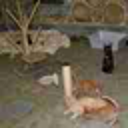

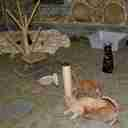

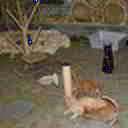

训练前噪音 33.3014 训练后噪音 33.7552 （越大越好）


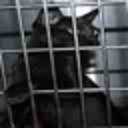

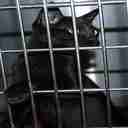

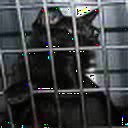

训练前噪音 31.0881 训练后噪音 31.1369 （越大越好）


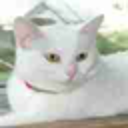

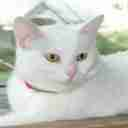

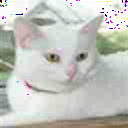

训练前噪音 37.4838 训练后噪音 37.4987 （越大越好）


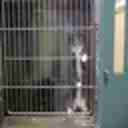

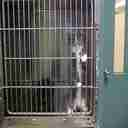

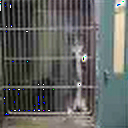

训练前噪音 29.8304 训练后噪音 29.9591 （越大越好）


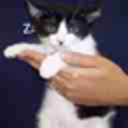

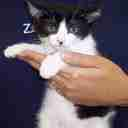

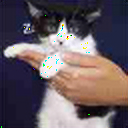

训练前噪音 35.1388 训练后噪音 35.3095 （越大越好）


In [42]:
for i in range(5):
    disp(i, mean_of_train, std_of_train, X_train, y_train, train_result)    

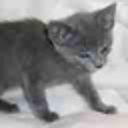

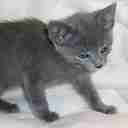

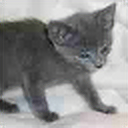

训练前噪音 36.8939 训练后噪音 36.9476 （越大越好）


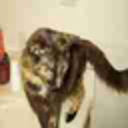

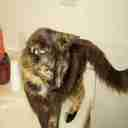

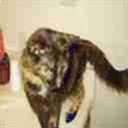

训练前噪音 34.2399 训练后噪音 34.5209 （越大越好）


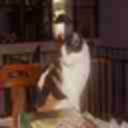

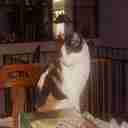

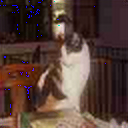

训练前噪音 34.3166 训练后噪音 34.5244 （越大越好）


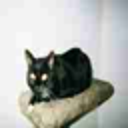

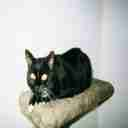

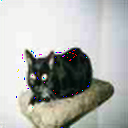

训练前噪音 35.8386 训练后噪音 35.9333 （越大越好）


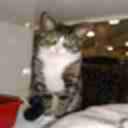

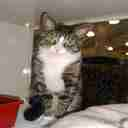

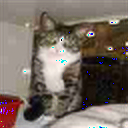

训练前噪音 33.5132 训练后噪音 33.5390 （越大越好）


In [43]:
for i in range(5):
    disp(i, mean_of_train, std_of_train, X_test, y_test, test_result)